In [2]:
import random
import numpy as np
import statistics 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from scipy import ndimage
from scipy import stats
from scipy.spatial import distance
from scipy.stats.stats import pearsonr 
import scipy.signal 
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

from sklearn import preprocessing
from itertools import cycle
import seaborn as sns
import math
from sklearn.model_selection import train_test_split

import matlab
import matlab.engine

#plotting params
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = '0.5'
mpl.rcParams['axes.labelsize'] = '15'
mpl.rcParams['axes.labelcolor'] = 'black'

mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['xtick.labelsize'] = '10'
mpl.rcParams['ytick.labelsize'] = '10'
mpl.rcParams['ytick.color'] = 'black'

In [3]:
animals = ['F', 'L', 'I']
for i in animals:
    insert_animal = i
    print(insert_animal)
    inputEventTrace = '/Users/rufusmitchell-heggs/Desktop/data/preprocessing/AN'+insert_animal+'/preprocessed_files/AN'+insert_animal+'mega_events.csv'
    inputTrace = '/Users/rufusmitchell-heggs/Desktop/data/preprocessing/AN'+insert_animal+'/preprocessed_files/AN'+insert_animal+'mega_trace.csv'
    inputcelllocation = '/Users/rufusmitchell-heggs/Desktop/data/preprocessing/AN'+insert_animal+'/AN'+insert_animal+'Traces-props.csv'

    data_event = pd.read_csv(inputEventTrace, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")
    data_trace = pd.read_csv(inputTrace, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")
    data_trace['unique_stage']=data_trace['stage']+data_trace['session'].astype(str)

    def get_session(data_event_or_data_trace):
        """"get session takes the mega_event or trace file in and returns a list of all the session blocks
        INPUT:
        -------
        >> data_event_or_data_trace - mega_events OR mega_trace file

        OUTPUT:
        -------
        >> blocks - a list of all events or traces as in dataframe format """

        batches_dic = {'Exp1':1, 'Pre1':2, 'Nov1':3, 'Exp2':4, 'Pre2':5, 'Nov2':6, 'Exp3':7, 'Nov3':8}
        batches = list(set(data_event_or_data_trace.unique_stage))
        sorted_batches = []
        for i in batches:
            sorted_batches.append(batches_dic[i])
        sorted_batches.sort()

        batches = []
        for i in sorted_batches:
            batches.append(list(batches_dic.keys())[list(batches_dic.values()).index(i)])

        blocks = []
        for batch in batches:
            blocks.append(data_event_or_data_trace[data_event_or_data_trace['unique_stage']==batch])

        return blocks

    traces = get_session(data_trace)
    events = get_session(data_event)

    events = [events[1], events[2], events[4], events[5], events[7]]
    traces = [traces[1], traces[2], traces[4], traces[5], traces[7]]

    # Cells that are on all days

    # cell_all_days = pd.read_csv(inputcelllocation, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")
    # cell_all_days = np.array(cell_all_days)

    # exp_all, pre_all, nov_all = [[], [], []]
    # for i in range(len(cell_all_days)):
    #     row = cell_all_days[i]
    #     if row[9] == '1' == row[12] == row[15]:
    #         exp_all.append(' '+row[0])
    #     if row[10] == '1' == row[13]:
    #         pre_all.append(' '+row[0])
    #     if row[11] == '1' == row[14] == row[16]:
    #         nov_all.append(' '+row[0])

    AN_df = pd.read_csv('/Users/rufusmitchell-heggs/Desktop/data/preprocessing/AN'+insert_animal+'/preprocessed_files/onoff.csv')

    AN_df_on, AN_df_off  = [np.array(AN_df.loc[:, AN_df.columns.str.contains('on')]).transpose(),  np.array(AN_df.loc[:, AN_df.columns.str.contains('off')]).transpose()]

    AN_on_all = []
    AN_off_all = []
    for stage in range(len(AN_df_on)):
        on_list = []
        off_list = []
        for _on, _off in zip(AN_df_on[stage], AN_df_off[stage]):
            if len(str(_on)) > 1:
                on_list.append(_on)
            if len(str(_off)) > 1:
                off_list.append(_off)
        AN_on_all.append(on_list)
        AN_off_all.append(off_list)
    for blahblah in range(len(events)):
        sesh = blahblah
        stranger = 2

        ## --------------------------------------------------------------------------------------------------
        traces_session = traces[sesh]
        events_session = events[sesh]
        
        print(np.array(traces_session['unique_stage'])[0])



        # if sesh ==0 or sesh == 3 or sesh == 6:
        #     cells_dictionary = exp_all
        # elif sesh == 1 or sesh == 4:
        #     cells_dictionary = pre_all
        # else:
        #     cells_dictionary = nov_all

        animal_cell_count = {'F':238, 'I':126, 'L':74}
        all_cells = traces_session.iloc[: , 2:animal_cell_count[insert_animal]] #<---- (ANF - 238 cells, ANI - 126 cells, ANL - 74 cells)
        cells_dictionary = traces_session.iloc[: , 2:animal_cell_count[insert_animal]].loc[:,~(traces_session==" nan").any()].columns.values
        nan_cells = (set(all_cells.columns.values).difference(cells_dictionary))

        AN_other = []
        for i in cells_dictionary:
            if i not in AN_on_all[sesh] and i not in AN_off_all[sesh]:
                AN_other.append(i)

        data_trace = np.array(traces_session[cells_dictionary].astype(float)).transpose()
        data_events=np.array(events_session[cells_dictionary].astype(float)).transpose()
        data_events_normalized = normalize(data_events, axis=1)

        behav_vector = np.array(traces_session['raw_behaviour'].astype(float))

        cage = stranger
        behav_vec_cropped = []
        for i in behav_vector:
            if cage == 2:
                if i == 2:
                    behav_vec_cropped.append(1)
                elif i == 1:
                    behav_vec_cropped.append(0)
                else:
                    behav_vec_cropped.append(0) 
            elif cage == 1:
                if i == 2:
                    behav_vec_cropped.append(0)
                elif i == 1:
                    behav_vec_cropped.append(1)
                else:
                    behav_vec_cropped.append(0) 
            elif cage == 'both':
                if i > 0:
                    behav_vec_cropped.append(1)
                else:
                    behav_vec_cropped.append(0) 

        behav_vector = np.array(behav_vec_cropped)

        #--------------------------------------------------------------------------------------------------
        #Create binary spike train
        data_events_binarized = []
        for neuron in range(len(data_events)):
            neuron_events_binarised = []
            for event in data_events[neuron]:
                if event > 0:
                    neuron_events_binarised.append(1)
                else:
                    neuron_events_binarised.append(0)
            data_events_binarized.append(neuron_events_binarised)
        data_events_binarized = np.array(data_events_binarized)

        def event_categorization(event_trace, bin_size = 0.25):
            """"Categorize all event traces into different bins of spike amplitudes.
            Due to low resolution, we can account for any lost spikes and weight events accordingly"""
            bin_size = bin_size #<---- must be greater than 0.25
            all_events = []
            data_events_categorised = []
            for neuron in range(len(event_trace)):
                neuron_events_categorised = []
                for event in event_trace[neuron]:
                    if event > 0:
                        if event < bin_size:
                            neuron_events_categorised.append(1)
                        elif bin_size < event < (bin_size*2):
                            neuron_events_categorised.append(2)
                        elif (bin_size*2) < event < (bin_size*3):
                            neuron_events_categorised.append(3)
                        elif (bin_size*3) < event :
                            neuron_events_categorised.append(4)
                    else:
                        neuron_events_categorised.append(0)         
                data_events_categorised.append(neuron_events_categorised)
            return data_events_categorised

        data_events_categorised = event_categorization(data_events_normalized, bin_size = 0.25)

        #--------------------------------------------------------------------------------------------------
        def spike_binning(spike_array, bin_size=10):
            bin_size = bin_size
            binned_spikes = []
            for neuron in spike_array:
                per_neuron=[]
                i=0
                while i <= len(neuron):
                    per_neuron.append(sum(neuron[i:i+bin_size]))
                    i+=bin_size
                binned_spikes.append(per_neuron)
            return binned_spikes

        def behav_vector_binning(behav_vector, bin_size=10):
            bin_size = bin_size
            binned_behav_vector = []
            i=0
            while i <= len(behav_vector):
                binned_behav_vector.append(stats.mode(behav_vector[i:i+bin_size])[0])
                i+=bin_size
            return binned_behav_vector

        binned_data_events_binarized = np.array(spike_binning(data_events_binarized))
        binned_data_events_categorised = np.array(spike_binning(data_events_categorised))
        binned_behav_vector = np.array(behav_vector_binning(behav_vector)).transpose().tolist()[0]

        empty = []
        empty_binary = []
        for i in range(len(binned_data_events_categorised)):
            if sum(binned_data_events_categorised[i]) == 0:
                empty.append(i)
            if sum(binned_data_events_binarized[i]) == 0:
                empty_binary.append(i)

        binned_data_events_categorised = np.delete(binned_data_events_categorised, empty, 0).transpose()
        binned_data_events_binarized = np.delete(binned_data_events_binarized, empty_binary, 0).transpose()

        cells_dictionary = np.delete(cells_dictionary, empty, 0)

        binned_data_events_categorised = binned_data_events_categorised.transpose()
        binned_data_events_binarized = binned_data_events_binarized.transpose()
        #--------------------------------------------------------------------------------------------------
        entropies=[]
        for neuron in range(len(binned_data_events_categorised)): 
            #Define probability of each neuron firing
            count_individ_dic = {0:0, 1:0}
            for spike in binned_data_events_categorised[neuron]:
                spike_count_entry = int(spike)
                if spike_count_entry > 0:
                    count_individ_dic[1] += spike*1
                else:
                    count_individ_dic[0] += 1 

            probability_response_dic = {}
            for key in count_individ_dic:
                probability_response_dic[key] = count_individ_dic[key]/sum(count_individ_dic.values())

            #define entropy for every neuron
            entropyr = 0
            for key in probability_response_dic:
                entropyr += -(probability_response_dic[key]*math.log2(probability_response_dic[key]))
            entropies.append(entropyr)
        #--------------------------------------------------------------------------------------------------

        #Joint entropies
        mi_all = []
        mutual_info_dis_all = []
        for neuron1 in range(len(binned_data_events_categorised)):
            mutual_info_dis = []
            mi = []
            for neuron2 in range(len(binned_data_events_categorised)):
                #intialise count__spike_behav_dic
                count__spike_spike_dic = {'count00':0,'count01':0,'count10':0, 'count11':0}
                #How many spikes are there during each behaviour
                for spikei, spikej in zip(binned_data_events_categorised[neuron1], binned_data_events_categorised[neuron2]):                     
                        if int(spikei) > int(spikej):
                            count__spike_spike_dic['count11'] += spikej*1
                            count__spike_spike_dic['count10'] += int(spikei-spikej)*1
                        elif int(spikei) < int(spikej):
                            count__spike_spike_dic['count11'] += spikei*1
                            count__spike_spike_dic['count01'] += int(spikej-spikei)*1
                        elif int(spikei) == int(spikej) and spikei >0:
                            count__spike_spike_dic['count11'] += spikei*1
                        else:
                            count__spike_spike_dic['count00'] += 1
                #What is the probability of that spike during the behaviour
                probability_spike_spike_dic = {}         
                for key in count__spike_spike_dic:
                    probability_spike_spike_dic[key] = count__spike_spike_dic[key]/sum(count__spike_spike_dic.values())

                entropy_spike_spike_dic = {}         
                for key in probability_spike_spike_dic:
                    if probability_spike_spike_dic[key] > 0:
                        entropy_spike_spike_dic[key] = probability_spike_spike_dic[key]*math.log2(1/probability_spike_spike_dic[key])
                    else:
                        entropy_spike_spike_dic[key] = 0
                j_entropy = sum(entropy_spike_spike_dic.values())
                if neuron1 != neuron2:
                    mutual_info = entropies[neuron1] + entropies[neuron2] - j_entropy
                else:
                    mutual_info = np.nan
                mi.append(mutual_info)
                mutual_info_dis.append(1-(mutual_info/j_entropy))
            mi_all.append(mi)
            mutual_info_dis_all.append(mutual_info_dis)
        #--------------------------------------------------------------------------------------------------

        mutual_info_dis_all = np.array(mutual_info_dis_all)
        mi_all = np.array(mi_all)
        
        def pairwise_mi(ONorOFF1, ONorOFF2, cells_dictionary, mutual_info_dis_all):

            ONorOFF_cells_dictionary1 = ONorOFF1[sesh]
            ONorOFF_cells_dictionary2 = ONorOFF2[sesh]

            ONorOFF1 = []
            ONorOFF2 = []
            for i in range(len(cells_dictionary)):
                if cells_dictionary[i] in ONorOFF_cells_dictionary1:
                    ONorOFF1.append(i)
                if cells_dictionary[i] in ONorOFF_cells_dictionary2:
                    ONorOFF2.append(i)

            stage_information = []
            for i in ONorOFF1:
                for j in ONorOFF2:
                    if not np.isnan(mutual_info_dis_all[i][j]):
                        stage_information.append(mutual_info_dis_all[i][j])
            return stage_information

        if insert_animal == 'F':
            if np.array(traces_session['unique_stage'])[0] == 'Pre1':
                print('hello')
                ANF_pre1_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANF_pre1_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANF_pre1_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANF_pre1_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANF_pre1_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)
            elif np.array(traces_session['unique_stage'])[0] == 'Pre2':
                ANF_pre2_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANF_pre2_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANF_pre2_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANF_pre2_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANF_pre2_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)

            elif np.array(traces_session['unique_stage'])[0] == 'Nov1':
                ANF_nov1_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANF_nov1_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANF_nov1_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANF_nov1_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANF_nov1_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)
            elif np.array(traces_session['unique_stage'])[0] == 'Nov2':
                ANF_nov2_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANF_nov2_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANF_nov2_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANF_nov2_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANF_nov2_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)
            elif np.array(traces_session['unique_stage'])[0] == 'Nov3':
                ANF_nov3_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANF_nov3_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANF_nov3_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANF_nov3_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANF_nov3_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)

        if insert_animal == 'L':
            if np.array(traces_session['unique_stage'])[0] == 'Pre1':
                ANL_pre1_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANL_pre1_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANL_pre1_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANL_pre1_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANL_pre1_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)
            elif np.array(traces_session['unique_stage'])[0] == 'Pre2':
                ANL_pre2_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANL_pre2_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANL_pre2_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANL_pre2_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANL_pre2_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)

            elif np.array(traces_session['unique_stage'])[0] == 'Nov1':
                ANL_nov1_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANL_nov1_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANL_nov1_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANL_nov1_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANL_nov1_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)
            elif np.array(traces_session['unique_stage'])[0] == 'Nov2':
                ANL_nov2_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANL_nov2_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANL_nov2_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANL_nov2_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANL_nov2_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)
            elif np.array(traces_session['unique_stage'])[0] == 'Nov3':
                ANL_nov3_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANL_nov3_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANL_nov3_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANL_nov3_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANL_nov3_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)

        if insert_animal == 'I':
            if np.array(traces_session['unique_stage'])[0] == 'Pre1':
                ANI_pre1_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANI_pre1_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANI_pre1_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANI_pre1_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANI_pre1_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)
            elif np.array(traces_session['unique_stage'])[0] == 'Pre2':
                ANI_pre2_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANI_pre2_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANI_pre2_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANI_pre2_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANI_pre2_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)

            elif np.array(traces_session['unique_stage'])[0] == 'Nov1':
                ANI_nov1_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANI_nov1_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANI_nov1_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANI_nov1_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANI_nov1_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)
            elif np.array(traces_session['unique_stage'])[0] == 'Nov2':
                ANI_nov2_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANI_nov2_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANI_nov2_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANI_nov2_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANI_nov2_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)
            elif np.array(traces_session['unique_stage'])[0] == 'Nov3':
                ANI_nov3_onon = pairwise_mi(AN_on_all, AN_on_all,cells_dictionary, mi_all)
                ANI_nov3_offoff = pairwise_mi(AN_off_all, AN_off_all,cells_dictionary, mi_all)
                ANI_nov3_onoff = pairwise_mi(AN_on_all, AN_off_all,cells_dictionary, mi_all)
                ANI_nov3_onother = pairwise_mi(AN_on_all, AN_other,cells_dictionary, mi_all)
                ANI_nov3_other = pairwise_mi(AN_off_all, AN_other,cells_dictionary, mi_all)


  

F
Pre1
hello
Nov1
Pre2
Nov2
Nov3
L
Pre1
Nov1
Pre2
Nov2
Nov3
I
Pre1
Nov1
Pre2
Nov2
Nov3


In [4]:
wt_avg_onon = np.nanmean([np.mean(np.array(ANF_pre1_onon)),np.mean(np.array(ANF_pre2_onon)),np.mean(np.array(ANF_nov1_onon)),np.mean(np.array(ANF_nov2_onon)),np.mean(np.array(ANF_nov3_onon))])
wt_sem_onon = stats.sem([np.mean(np.array(ANF_pre1_onon)),np.mean(np.array(ANF_pre2_onon)),np.mean(np.array(ANF_nov1_onon)),np.mean(np.array(ANF_nov2_onon)),np.mean(np.array(ANF_nov3_onon))], nan_policy='omit')
wt_avg_offoff = np.nanmean([np.mean(np.array(ANF_pre1_offoff)),np.mean(np.array(ANF_pre2_offoff)),np.mean(np.array(ANF_nov1_offoff)),np.mean(np.array(ANF_nov2_offoff)),np.mean(np.array(ANF_nov3_offoff))])
wt_sem_offoff = stats.sem([np.mean(np.array(ANF_pre1_offoff)),np.mean(np.array(ANF_pre2_offoff)),np.mean(np.array(ANF_nov1_offoff)),np.mean(np.array(ANF_nov2_offoff)),np.mean(np.array(ANF_nov3_offoff))], nan_policy='omit')
wt_avg_onoff = np.nanmean([np.mean(np.array(ANF_pre1_onoff)),np.mean(np.array(ANF_pre2_onoff)),np.mean(np.array(ANF_nov1_onoff)),np.mean(np.array(ANF_nov2_onoff)),np.mean(np.array(ANF_nov3_onoff))])
wt_sem_onoff = stats.sem([np.mean(np.array(ANF_pre1_onoff)),np.mean(np.array(ANF_pre2_onoff)),np.mean(np.array(ANF_nov1_onoff)),np.mean(np.array(ANF_nov2_onoff)),np.mean(np.array(ANF_nov3_onoff))], nan_policy='omit')

wt_avg_onoffother = np.nanmean([np.mean(np.array(ANF_pre1_onother)),np.mean(np.array(ANF_pre2_onother)),np.mean(np.array(ANF_nov1_onother)),np.mean(np.array(ANF_nov2_onother)),np.mean(np.array(ANF_nov3_onother)), np.mean(np.array(ANF_pre1_other)),np.mean(np.array(ANF_pre2_other)),np.mean(np.array(ANF_nov1_other)),np.mean(np.array(ANF_nov2_other)),np.mean(np.array(ANF_nov3_other))])
wt_sem_onoffother = stats.sem([np.mean(np.array(ANF_pre1_onother)),np.mean(np.array(ANF_pre2_onother)),np.mean(np.array(ANF_nov1_onother)),np.mean(np.array(ANF_nov2_onother)),np.mean(np.array(ANF_nov3_onother)), np.mean(np.array(ANF_pre1_other)),np.mean(np.array(ANF_pre2_other)),np.mean(np.array(ANF_nov1_other)),np.mean(np.array(ANF_nov2_other)),np.mean(np.array(ANF_nov3_other))], nan_policy='omit')

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


WT 0.003001521628438719 0.0014366650907924844 0.0013254148409539432 0.001225856219671045
KO 0.001219802239397022 0.007373206124302184 0.0016694000310121476 0.0011215370619931924
WT 0.004811043505608355 0.0011613915621531351 0.0006629815575356463 0.00048279113259167277
KO 0.000680314094061476 0.017680527277657516 0.000712468693580242 0.0005085520339862519
0.08233030045624562
0.08233030045624562
0.04192968274005526
0.10559800588996371
0.04587042294609339
0.07145084415001157
0.0792910110272621
0.04192968274005526
0.04665981966260563
0.0634868672629445
0.04972890376984079
0.05265974726958028
0.10559800588996376
0.04665981966260563
0.04847169077647956
0.07342735880349471
0.07522760486846652
0.04587042294609334
0.0634868672629445
0.048471690776479504
0.07617049935361109
0.07838925403823527
0.0792435106496091
0.07145084415001157
0.04972890376984079
0.07342735880349471
0.07617049935361109
0.18226568078938066
0.0792910110272621
0.05265974726958028
0.07522760486846652
0.07838925403823527
0.18226

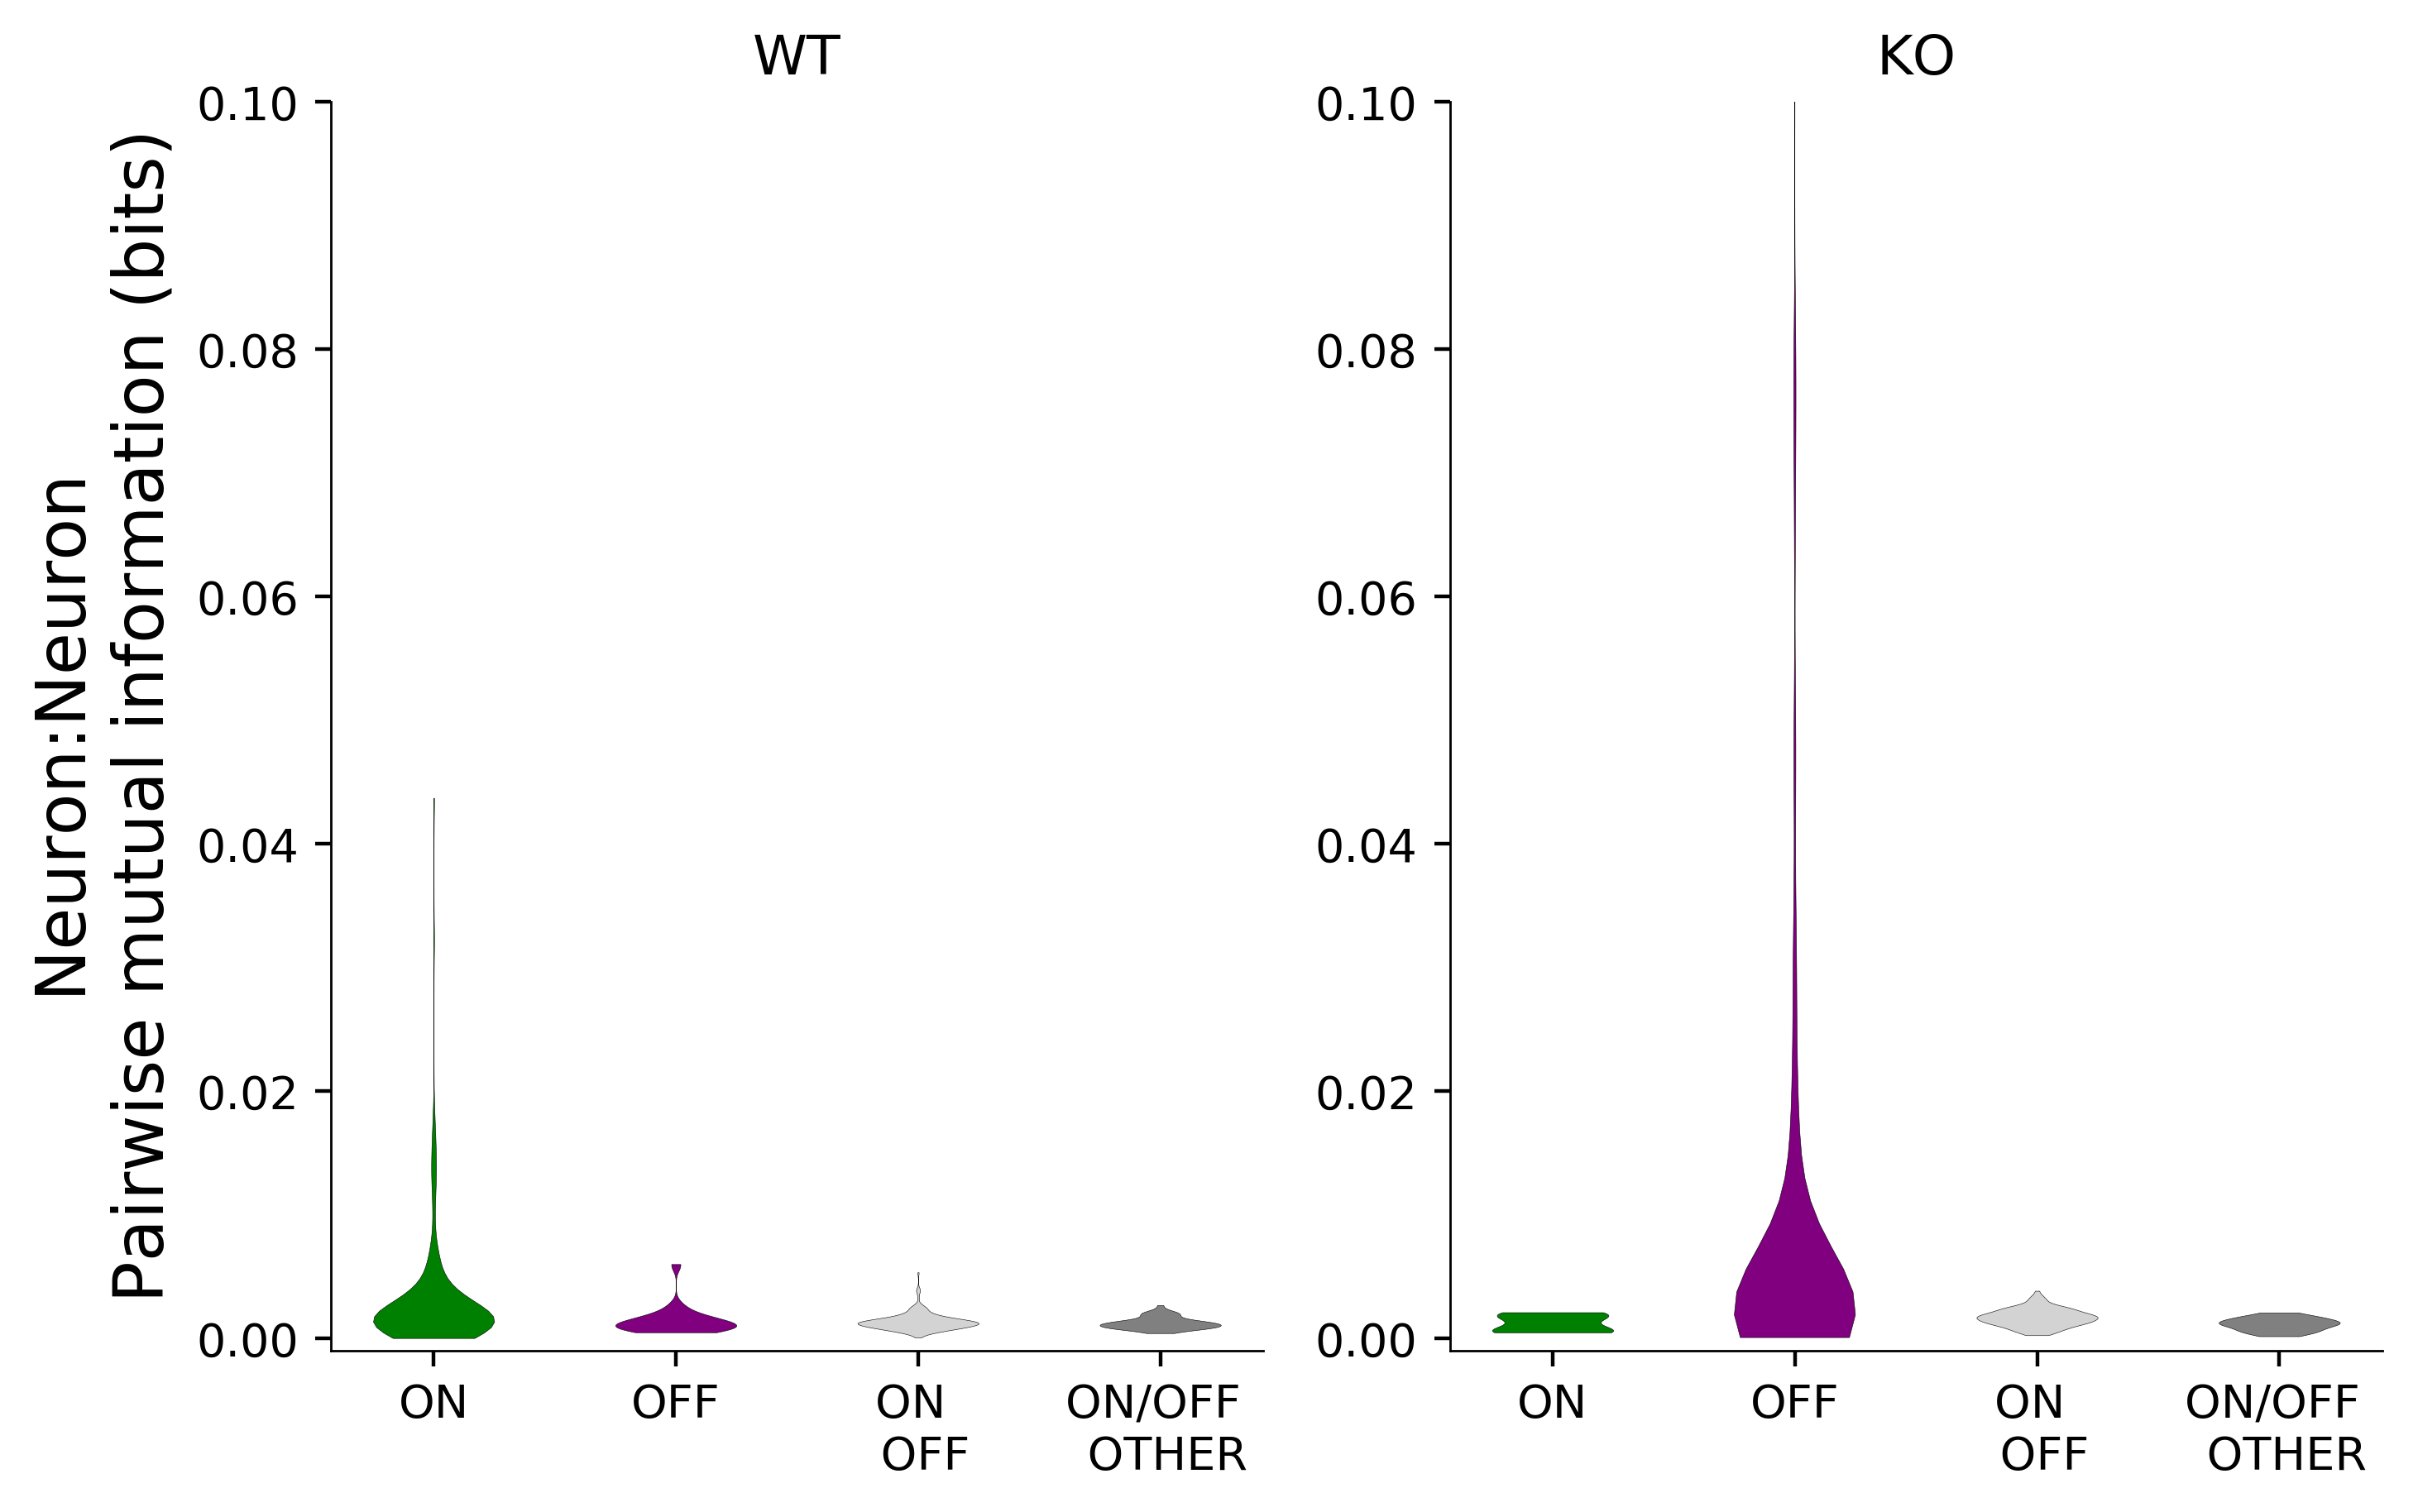

In [30]:
wt_avg_onon = np.array([item for sublist in [np.array(ANF_pre1_onon),np.array(ANF_pre2_onon),np.array(ANF_nov1_onon),np.array(ANF_nov2_onon),np.array(ANF_nov3_onon)] for item in sublist])
wt_avg_offoff = np.array([item for sublist in [np.array(ANF_pre1_offoff),np.array(ANF_pre2_offoff),np.array(ANF_nov1_offoff),np.array(ANF_nov2_offoff),np.array(ANF_nov3_offoff)] for item in sublist])
wt_avg_onoff = np.array([item for sublist in [np.array(ANF_pre1_onoff),np.array(ANF_pre2_onoff),np.array(ANF_nov1_onoff),np.array(ANF_nov2_onoff),np.array(ANF_nov3_onoff)] for item in sublist])
wt_avg_onoffother = np.array([item for sublist in [np.array(ANF_pre1_onother),np.array(ANF_pre2_onother),np.array(ANF_nov1_onother),np.array(ANF_nov2_onother),np.array(ANF_nov3_onother), np.array(ANF_pre1_other),np.array(ANF_pre2_other),np.array(ANF_nov1_other),np.array(ANF_nov2_other),np.array(ANF_nov3_other)] for item in sublist])

ko_avg_onon = np.array([item for sublist in [np.array(ANL_pre1_onon),np.array(ANL_pre2_onon),np.array(ANL_nov1_onon),np.array(ANL_nov2_onon),np.array(ANL_nov3_onon), np.array(ANI_pre1_onon),np.array(ANI_pre2_onon),np.array(ANI_nov1_onon),np.array(ANI_nov2_onon),np.array(ANI_nov3_onon)] for item in sublist])
ko_avg_offoff = np.array([item for sublist in [np.array(ANL_pre1_offoff),np.array(ANL_pre2_offoff),np.array(ANL_nov1_offoff),np.array(ANL_nov2_offoff),np.array(ANL_nov3_offoff), np.array(ANI_pre1_offoff),np.array(ANI_pre2_offoff),np.array(ANI_nov1_offoff),np.array(ANI_nov2_offoff),np.array(ANI_nov3_offoff)] for item in sublist])
ko_avg_onoff = np.array([item for sublist in [np.array(ANL_pre1_onoff),np.array(ANL_pre2_onoff),np.array(ANL_nov1_onoff),np.array(ANL_nov2_onoff),np.array(ANL_nov3_onoff), np.array(ANI_pre1_onoff),np.array(ANI_pre2_onoff),np.array(ANI_nov1_onoff),np.array(ANI_nov2_onoff),np.array(ANI_nov3_onoff)] for item in sublist])
ko_avg_onoffother = np.array([item for sublist in [np.array(ANL_pre1_onother),np.array(ANL_pre2_onother),np.array(ANL_nov1_onother),np.array(ANL_nov2_onother),np.array(ANL_nov3_onother), np.array(ANL_pre1_other),np.array(ANL_pre2_other),np.array(ANL_nov1_other),np.array(ANL_nov2_other),np.array(ANL_nov3_other), np.array(ANI_pre1_onother),np.array(ANI_pre2_onother),np.array(ANI_nov1_onother),np.array(ANI_nov2_onother),np.array(ANI_nov3_onother), np.array(ANI_pre1_other),np.array(ANI_pre2_other),np.array(ANI_nov1_other),np.array(ANI_nov2_other),np.array(ANI_nov3_other)] for item in sublist])

wt_all = np.array([wt_avg_onon, wt_avg_offoff, wt_avg_onoff, wt_avg_onoffother])
ko_all = np.array([ko_avg_onon, ko_avg_offoff, ko_avg_onoff, ko_avg_onoffother])
print('WT', np.mean(wt_avg_onon), np.mean(wt_avg_offoff), np.mean(wt_avg_onoff),np.mean(wt_avg_onoffother))
print('KO', np.mean(ko_avg_onon), np.mean(ko_avg_offoff), np.mean(ko_avg_onoff),np.mean(ko_avg_onoffother))

print('WT', np.std(wt_avg_onon), np.std(wt_avg_offoff), np.std(wt_avg_onoff),np.std(wt_avg_onoffother))
print('KO', np.std(ko_avg_onon), np.std(ko_avg_offoff), np.std(ko_avg_onoff),np.std(ko_avg_onoffother))

for i in ko_all[1]:
    if i > 0.04:
        print(i)
        
#plotting params
loc = range(1, len(wt_all)+1)
labels = ['ON','OFF','ON \n OFF','ON/OFF \n OTHER']
colors = ['green',
          'purple',
          'lightgray',
          'gray']



fig, axs = plt.subplots(1, 2, figsize=(8,5), dpi=400, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(1, 2)

axs[0] = plt.subplot(gs[0])
axs[0] = plt.violinplot(wt_all, showextrema = False)
plt.xticks(loc, labels)
plt.grid(False)
sns.despine()
for pc, color in zip(axs[0]['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(1)
    pc.set_edgecolor('black')
    pc.set_linewidth(0.1)
axs[0] = plt.title('WT')
axs[0] = plt.ylabel("Neuron:Neuron \n Pairwise mutual information (bits)")
axs[0] = plt.ylim(-0.001, 0.1)

axs[1] = plt.subplot(gs[1])
axs[1] = plt.violinplot(ko_all, showextrema = False)

plt.xticks(loc, labels)
plt.grid(False)
sns.despine()

for pc, color in zip(axs[1]['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(1)
    pc.set_edgecolor('black')
    pc.set_linewidth(0.1)
axs[1] = plt.title('KO')    
axs[1] = plt.ylim(-0.001, 0.1)
plt.show()


In [6]:
ko_avg_onon = np.nanmean([np.mean(np.array(ANL_pre1_onon)),np.mean(np.array(ANL_pre2_onon)),np.mean(np.array(ANL_nov1_onon)),np.mean(np.array(ANL_nov2_onon)),np.mean(np.array(ANL_nov3_onon)), np.mean(np.array(ANI_pre1_onon)),np.mean(np.array(ANI_pre2_onon)),np.mean(np.array(ANI_nov1_onon)),np.mean(np.array(ANI_nov2_onon)),np.mean(np.array(ANI_nov3_onon))])
ko_sem_onon = stats.sem([np.mean(np.array(ANL_pre1_onon)),np.mean(np.array(ANL_pre2_onon)),np.mean(np.array(ANL_nov1_onon)),np.mean(np.array(ANL_nov2_onon)),np.mean(np.array(ANL_nov3_onon)), np.mean(np.array(ANI_pre1_onon)),np.mean(np.array(ANI_pre2_onon)),np.mean(np.array(ANI_nov1_onon)),np.mean(np.array(ANI_nov2_onon)),np.mean(np.array(ANI_nov3_onon))], nan_policy='omit')
ko_avg_offoff = np.nanmean([np.mean(np.array(ANL_pre1_offoff)),np.mean(np.array(ANL_pre2_offoff)),np.mean(np.array(ANL_nov1_offoff)),np.mean(np.array(ANL_nov2_offoff)),np.mean(np.array(ANL_nov3_offoff)), np.mean(np.array(ANI_pre1_offoff)),np.mean(np.array(ANI_pre2_offoff)),np.mean(np.array(ANI_nov1_offoff)),np.mean(np.array(ANI_nov2_offoff)),np.mean(np.array(ANI_nov3_offoff))])
ko_sem_offoff = stats.sem([np.mean(np.array(ANL_pre1_offoff)),np.mean(np.array(ANL_pre2_offoff)),np.mean(np.array(ANL_nov1_offoff)),np.mean(np.array(ANL_nov2_offoff)),np.mean(np.array(ANL_nov3_offoff)), np.mean(np.array(ANI_pre1_offoff)),np.mean(np.array(ANI_pre2_offoff)),np.mean(np.array(ANI_nov1_offoff)),np.mean(np.array(ANI_nov2_offoff)),np.mean(np.array(ANI_nov3_offoff))], nan_policy='omit')
ko_avg_onoff = np.nanmean([np.mean(np.array(ANL_pre1_onoff)),np.mean(np.array(ANL_pre2_onoff)),np.mean(np.array(ANL_nov1_onoff)),np.mean(np.array(ANL_nov2_onoff)),np.mean(np.array(ANL_nov3_onoff)), np.mean(np.array(ANI_pre1_onoff)),np.mean(np.array(ANI_pre2_onoff)),np.mean(np.array(ANI_nov1_onoff)),np.mean(np.array(ANI_nov2_onoff)),np.mean(np.array(ANI_nov3_onoff))])
ko_sem_onoff = stats.sem([np.mean(np.array(ANL_pre1_onoff)),np.mean(np.array(ANL_pre2_onoff)),np.mean(np.array(ANL_nov1_onoff)),np.mean(np.array(ANL_nov2_onoff)),np.mean(np.array(ANL_nov3_onoff)), np.mean(np.array(ANI_pre1_onoff)),np.mean(np.array(ANI_pre2_onoff)),np.mean(np.array(ANI_nov1_onoff)),np.mean(np.array(ANI_nov2_onoff)),np.mean(np.array(ANI_nov3_onoff))], nan_policy='omit')

ko_avg_onoffother = np.nanmean([np.mean(np.array(ANL_pre1_onother)),np.mean(np.array(ANL_pre2_onother)),np.mean(np.array(ANL_nov1_onother)),np.mean(np.array(ANL_nov2_onother)),np.mean(np.array(ANL_nov3_onother)), np.mean(np.array(ANL_pre1_other)),np.mean(np.array(ANL_pre2_other)),np.mean(np.array(ANL_nov1_other)),np.mean(np.array(ANL_nov2_other)),np.mean(np.array(ANL_nov3_other)), np.mean(np.array(ANI_pre1_onother)),np.mean(np.array(ANI_pre2_onother)),np.mean(np.array(ANI_nov1_onother)),np.mean(np.array(ANI_nov2_onother)),np.mean(np.array(ANI_nov3_onother)), np.mean(np.array(ANI_pre1_other)),np.mean(np.array(ANI_pre2_other)),np.mean(np.array(ANI_nov1_other)),np.mean(np.array(ANI_nov2_other)),np.mean(np.array(ANI_nov3_other))])
ko_sem_onoffother = stats.sem([np.mean(np.array(ANL_pre1_onother)),np.mean(np.array(ANL_pre2_onother)),np.mean(np.array(ANL_nov1_onother)),np.mean(np.array(ANL_nov2_onother)),np.mean(np.array(ANL_nov3_onother)), np.mean(np.array(ANL_pre1_other)),np.mean(np.array(ANL_pre2_other)),np.mean(np.array(ANL_nov1_other)),np.mean(np.array(ANL_nov2_other)),np.mean(np.array(ANL_nov3_other)), np.mean(np.array(ANI_pre1_onother)),np.mean(np.array(ANI_pre2_onother)),np.mean(np.array(ANI_nov1_onother)),np.mean(np.array(ANI_nov2_onother)),np.mean(np.array(ANI_nov3_onother)), np.mean(np.array(ANI_pre1_other)),np.mean(np.array(ANI_pre2_other)),np.mean(np.array(ANI_nov1_other)),np.mean(np.array(ANI_nov2_other)),np.mean(np.array(ANI_nov3_other))], nan_policy='omit')


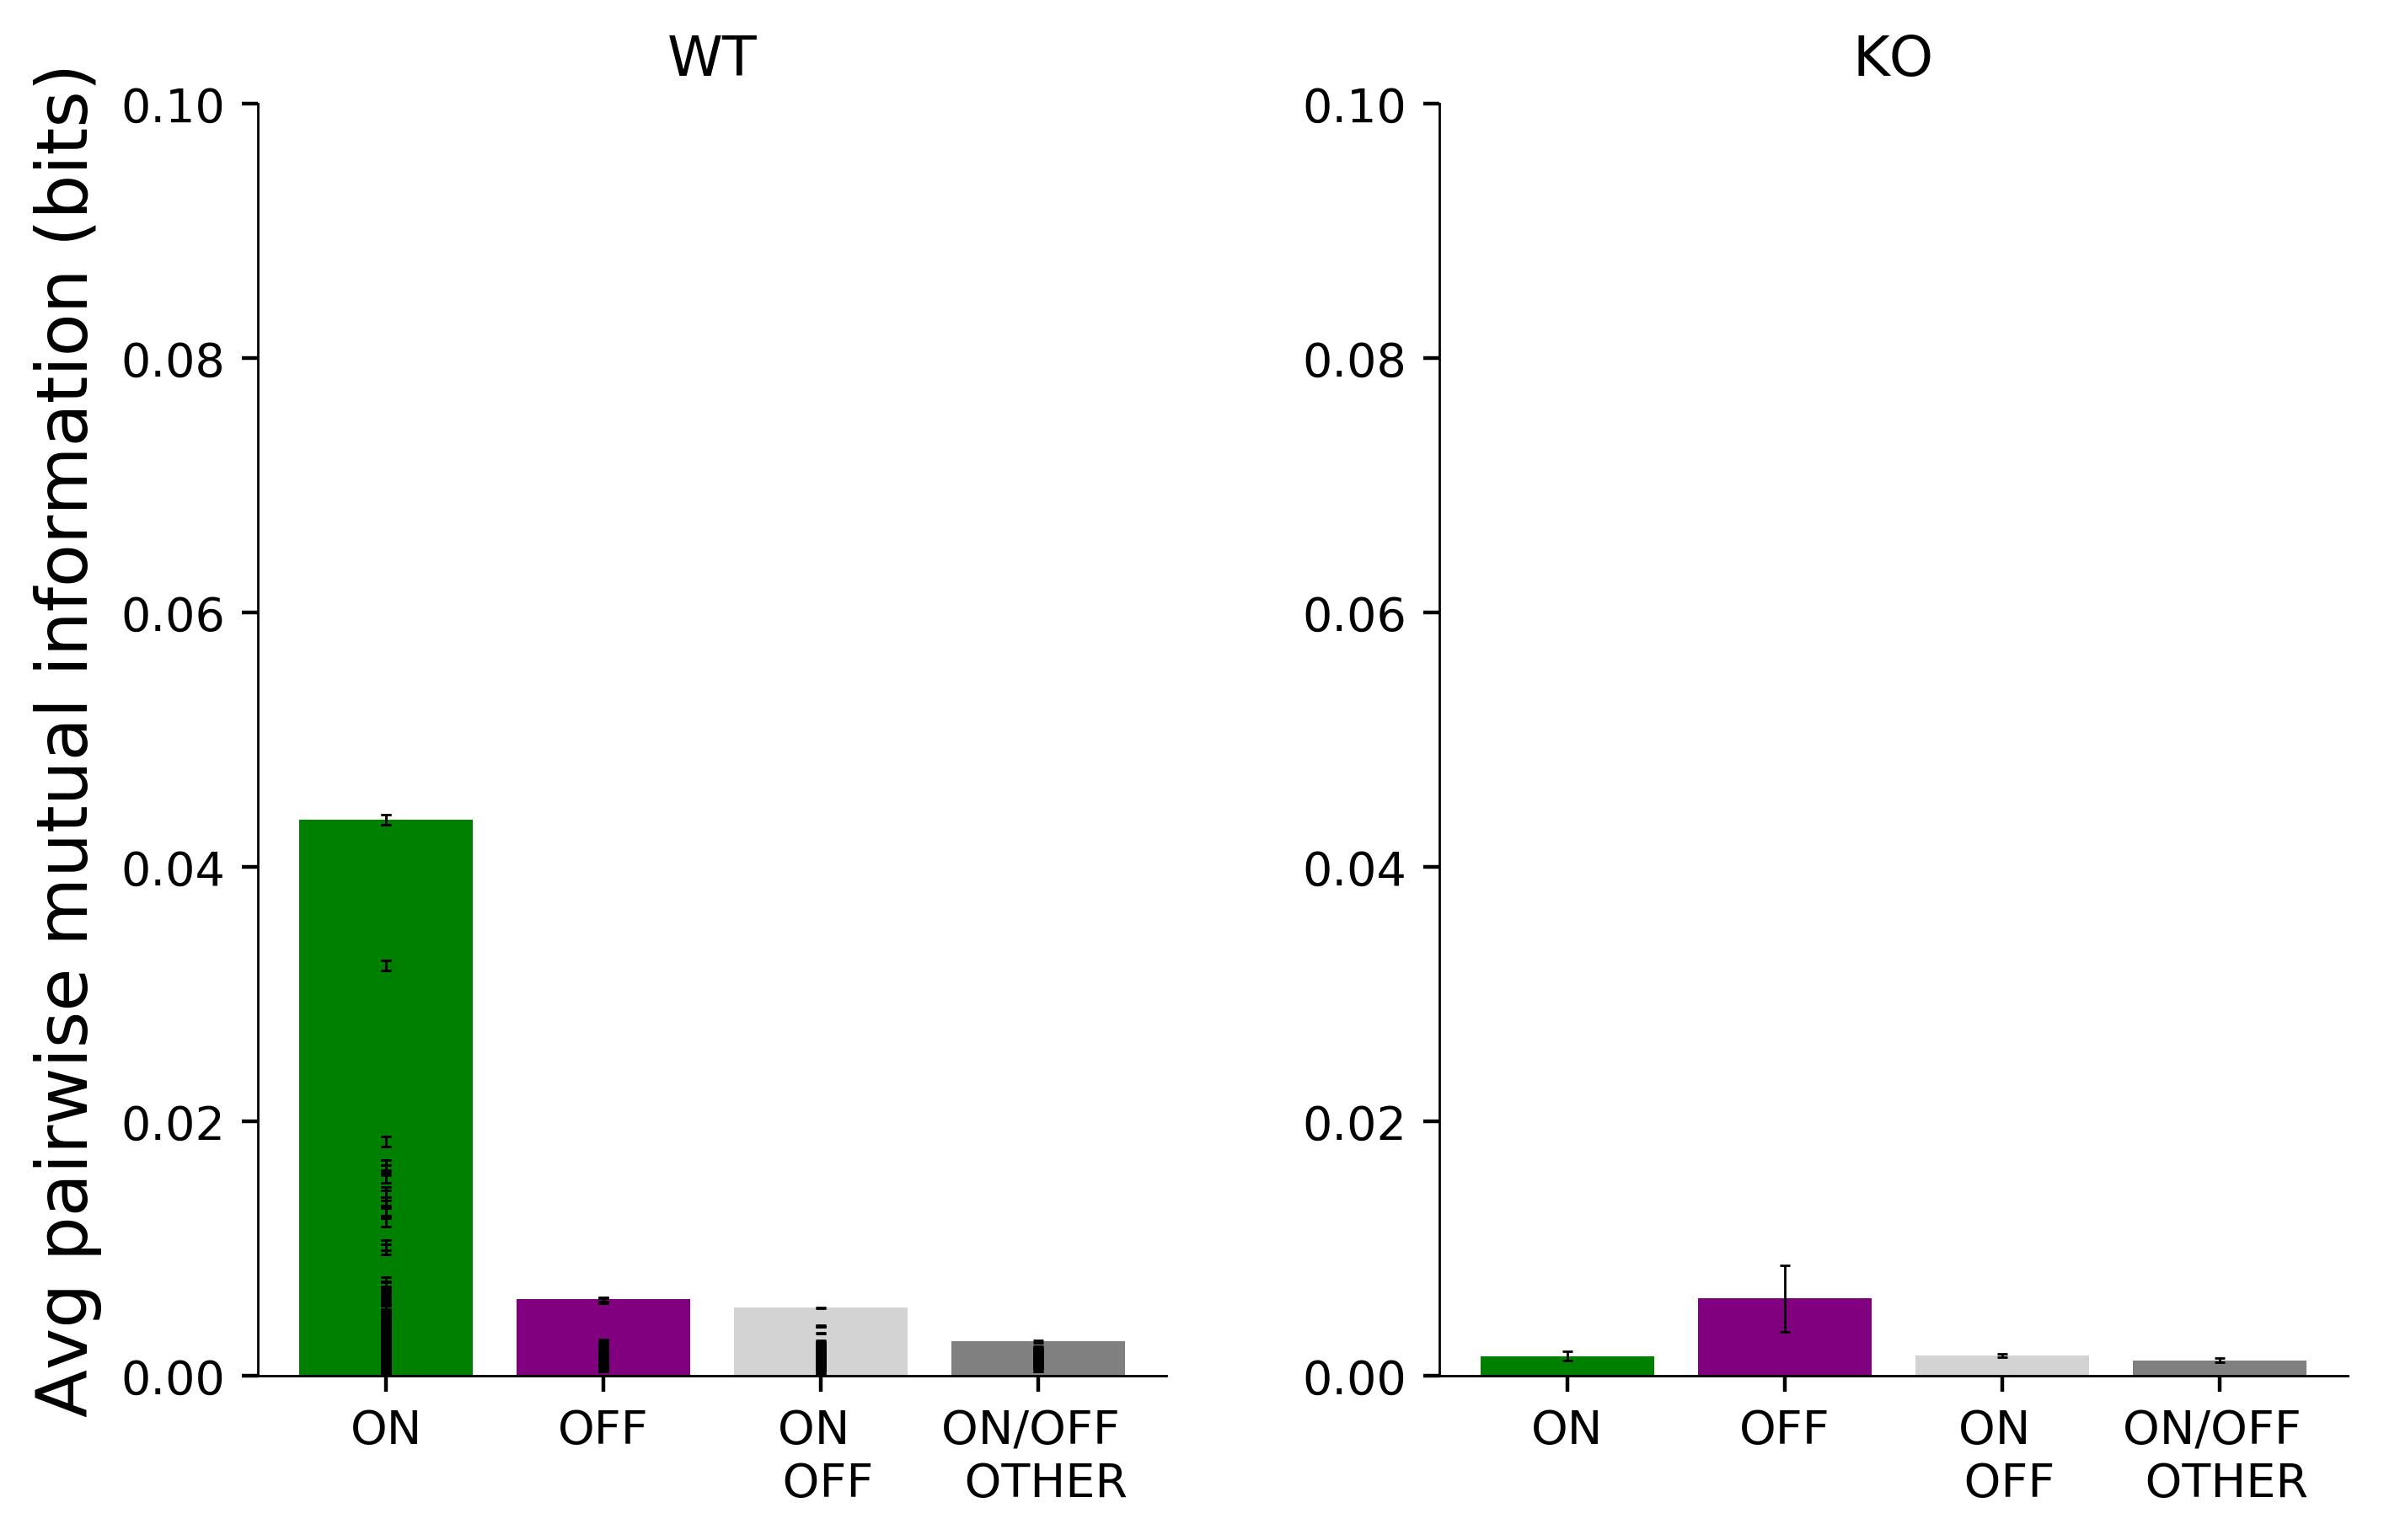

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8,5), dpi=400, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(1, 2)

axs[0] = plt.subplot(gs[0])
axs[0] = plt.bar(['ON'],wt_avg_onon, yerr=wt_sem_onon,error_kw=dict(lw=0.5, capsize=1, capthick=0.5), color='green')
axs[0] = plt.bar(['OFF'],wt_avg_offoff, yerr=wt_sem_offoff,error_kw=dict(lw=0.5, capsize=1, capthick=0.5),  color='purple')                                                                                    
axs[0] = plt.bar(['ON \n OFF'],wt_avg_onoff, yerr=wt_sem_onoff,error_kw=dict(lw=0.5, capsize=1, capthick=0.5), color='lightgray')                                                                                    
axs[0] = plt.bar(['ON/OFF \n OTHER'],wt_avg_onoffother, yerr=wt_sem_onoffother,error_kw=dict(lw=0.5, capsize=1, capthick=0.5), color='gray')                                                                                    

axs[0] = plt.tick_params(bottom=True, left=True, right=False, labelleft=True, labelbottom=True)
axs[0] = plt.title('WT')
axs[0] = plt.ylabel("Avg pairwise mutual information (bits)")
axs[0] = plt.ylim(0, 0.1)
axs[0] = sns.despine()

axs[1] = plt.subplot(gs[1])
axs[1] = plt.bar(['ON'],ko_avg_onon, yerr=ko_sem_onon,error_kw=dict(lw=0.5, capsize=1, capthick=0.5), color='green')
axs[1] = plt.bar(['OFF'],ko_avg_offoff, yerr=ko_sem_offoff,error_kw=dict(lw=0.5, capsize=1, capthick=0.5),  color='purple')                                                                                    
axs[1] = plt.bar(['ON \n OFF'],ko_avg_onoff, yerr=ko_sem_onoff,error_kw=dict(lw=0.5, capsize=1, capthick=0.5), color='lightgray')                                                                                    
axs[1] = plt.bar(['ON/OFF \n OTHER'],ko_avg_onoffother, yerr=ko_sem_onoffother,error_kw=dict(lw=0.5, capsize=1, capthick=0.5), color='gray')                                                                                    
axs[1] = plt.tick_params(bottom=True, left=True, right=False, labelleft=True, labelbottom=True)
axs[1] = plt.title('KO')
# axs[1] = plt.ylabel("Avg pairwise mutual information (bits)")
axs[1] = plt.ylim(0, 0.1)
axs[1] = sns.despine()
plt.subplots_adjust(wspace=0.3, hspace=0)

plt.savefig('/Users/rufusmitchell-heggs/Desktop/Thesis/all_figures/ONOFF_acrossdays(WTvsKO).png', format='png', dpi=600, bbox_inches = 'tight')
plt.show()

In [8]:
# avg_mi = np.mean(stage_information)
# sem_mi = stats.sem(stage_information)

print(np.nanmean(mutual_info_dis_all))

print(np.nanmean(mutual_info_dis_all))


 if insert_animal == 'F':
    if np.array(traces_session['unique_stage'])[0] == 'Pre1':
        if test == 'on':
            ANF_pre_on_on = pairwise_mutual_info(binned_data_events_categorised)[0]
        elif test == 'off':
            ANF_pre_off_off = pairwise_mutual_info(binned_data_events_categorised)[0]
        elif test == 'on'
    elif np.array(traces_session['unique_stage'])[0] == 'Pre2':
        ANF_x_Pre2, ANF_y_Pre2, ANF_err_Pre2, ANF_mi_Pre2 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all

    elif np.array(traces_session['unique_stage'])[0] == 'Nov1':
        ANF_x_Nov1, ANF_y_Nov1, ANF_err_Nov1, ANF_mi_Nov1 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
    elif np.array(traces_session['unique_stage'])[0] == 'Nov2':
        ANF_x_Nov2, ANF_y_Nov2, ANF_err_Nov2, ANF_mi_Nov2 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
    elif np.array(traces_session['unique_stage'])[0] == 'Nov3':
        ANF_x_Nov3, ANF_y_Nov3, ANF_err_Nov3, ANF_mi_Nov3 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all

if insert_animal == 'L':

if insert_animal == 'I':


IndentationError: unexpected indent (<ipython-input-8-f8f97f0be607>, line 9)

In [ ]:
# def euclidean_dis(xy1,xy2):
#     euc_dis_all = []
#     for i in xy1:
#         euc_dis = []
#         for j in xy2:
#             euc_dis.append(distance.euclidean(i, j)/1.42)
#         euc_dis_all.append(euc_dis)
#     return euc_dis_all

# cell_locations = pd.read_csv(inputcelllocation, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")
# cell_locations['Name'] = ' '+cell_locations['Name']
# stage_all = pd.DataFrame({'Name':cells_dictionary})
# stage_all_cell_locations = pd.merge(stage_all, cell_locations, on="Name")

# xy = np.array([stage_all_cell_locations['CentroidX'].astype(float), stage_all_cell_locations['CentroidY'].astype(float)]).transpose()
# euc_dis_all = np.array(euclidean_dis(xy, xy))

# window_size = 50
# window_edge = window_size
# window_start = 1
# avg_cross_cor_all = []
# error_cross_cor_all = []
# euc_dis_windows = []

# while window_edge <500:  
#     avg_neuron_cross_cor = []
#     for neuron in range(len(euc_dis_all)):
#         for i in range(len(euc_dis_all[neuron])):
#             if window_start <= euc_dis_all[neuron][i] <= window_edge:
#                 avg_neuron_cross_cor.append(mutual_info_dis_all[neuron][i])
#     avg_cross_cor_all.append(statistics.mean(avg_neuron_cross_cor))
#     error_cross_cor_all.append(stats.sem(avg_neuron_cross_cor))
#     euc_dis_windows.append(window_edge)
#     window_edge+=window_size
#     window_start+=window_size

# x_axis = euc_dis_windows #Euclidean distance 
# y_axis = avg_cross_cor_all #cross cor distance



# fig = plt.figure(num=None, figsize=(10, 10), dpi=180, facecolor='w', edgecolor='k')
# plt.plot(x_axis, y_axis, color = 'k')
# plt.errorbar(x_axis, y_axis, yerr=error_cross_cor_all, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')

# plt.fill_between(np.array(x_axis), np.array(y_axis)-np.array(error_cross_cor_all), np.array(y_axis)+np.array(error_cross_cor_all), facecolor='lightgray')
# plt.xlabel(r'Euclidean distance' + '\n' + 'between neurons ($\mu$m)')
# plt.ylabel('Mutual information (bits)' + '\n' + 'between neurons')    
# plt.xlim(1, 500)
# plt.ylim(0, 0.1)
#--------------------------------------------------------------------------------------------------
# if insert_animal == 'F':
#     if np.array(traces_session['unique_stage'])[0] == 'Exp1':
#         ANF_x_Exp1, ANF_y_Exp1, ANF_err_Exp1, ANF_mi_Exp1  = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Exp2':
#         ANF_x_Exp2, ANF_y_Exp2, ANF_err_Exp2, ANF_mi_Exp2 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Exp3':
#         ANF_x_Exp3, ANF_y_Exp3, ANF_err_Exp3, ANF_mi_Exp3 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all

#     elif np.array(traces_session['unique_stage'])[0] == 'Pre1':
#         ANF_x_Pre1, ANF_y_Pre1, ANF_err_Pre1, ANF_mi_Pre1 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Pre2':
#         ANF_x_Pre2, ANF_y_Pre2, ANF_err_Pre2, ANF_mi_Pre2 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all

#     elif np.array(traces_session['unique_stage'])[0] == 'Nov1':
#         ANF_x_Nov1, ANF_y_Nov1, ANF_err_Nov1, ANF_mi_Nov1 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Nov2':
#         ANF_x_Nov2, ANF_y_Nov2, ANF_err_Nov2, ANF_mi_Nov2 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Nov3':
#         ANF_x_Nov3, ANF_y_Nov3, ANF_err_Nov3, ANF_mi_Nov3 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all

# if insert_animal == 'L':
#     if np.array(traces_session['unique_stage'])[0] == 'Exp1':
#         ANL_x_Exp1, ANL_y_Exp1, ANL_err_Exp1, ANL_mi_Exp1 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Exp2':
#         ANL_x_Exp2, ANL_y_Exp2, ANL_err_Exp2, ANL_mi_Exp2 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Exp3':
#         ANL_x_Exp3, ANL_y_Exp3, ANL_err_Exp3, ANL_mi_Exp3 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all

#     elif np.array(traces_session['unique_stage'])[0] == 'Pre1':
#         ANL_x_Pre1, ANL_y_Pre1, ANL_err_Pre1, ANL_mi_Pre1 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Pre2':
#         ANL_x_Pre2, ANL_y_Pre2, ANL_err_Pre2, ANL_mi_Pre2 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all

#     elif np.array(traces_session['unique_stage'])[0] == 'Nov1':
#         ANL_x_Nov1, ANL_y_Nov1, ANL_err_Nov1, ANL_mi_Nov1 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Nov2':
#         ANL_x_Nov2, ANL_y_Nov2, ANL_err_Nov2, ANL_mi_Nov2 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Nov3':
#         ANL_x_Nov3, ANL_y_Nov3, ANL_err_Nov3, ANL_mi_Nov3 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all

# if insert_animal == 'I':
#     if np.array(traces_session['unique_stage'])[0] == 'Exp1':
#         ANI_x_Exp1, ANI_y_Exp1, ANI_err_Exp1, ANI_mi_Exp1 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Exp2':
#         ANI_x_Exp2, ANI_y_Exp2, ANI_err_Exp2, ANI_mi_Exp2 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Exp3':
#         ANI_x_Exp3, ANI_y_Exp3, ANI_err_Exp3, ANI_mi_Exp3 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all

#     elif np.array(traces_session['unique_stage'])[0] == 'Pre1':
#         ANI_x_Pre1, ANI_y_Pre1, ANI_err_Pre1, ANI_mi_Pre1 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Pre2':
#         ANI_x_Pre2, ANI_y_Pre2, ANI_err_Pre2, ANI_mi_Pre2 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all

#     elif np.array(traces_session['unique_stage'])[0] == 'Nov1':
#         ANI_x_Nov1, ANI_y_Nov1, ANI_err_Nov1, ANI_mi_Nov1 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Nov2':
#         ANI_x_Nov2, ANI_y_Nov2, ANI_err_Nov2, ANI_mi_Nov2 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all
#     elif np.array(traces_session['unique_stage'])[0] == 'Nov3':
#         ANI_x_Nov3, ANI_y_Nov3, ANI_err_Nov3, ANI_mi_Nov3 = x_axis, y_axis, error_cross_cor_all, mutual_info_dis_all





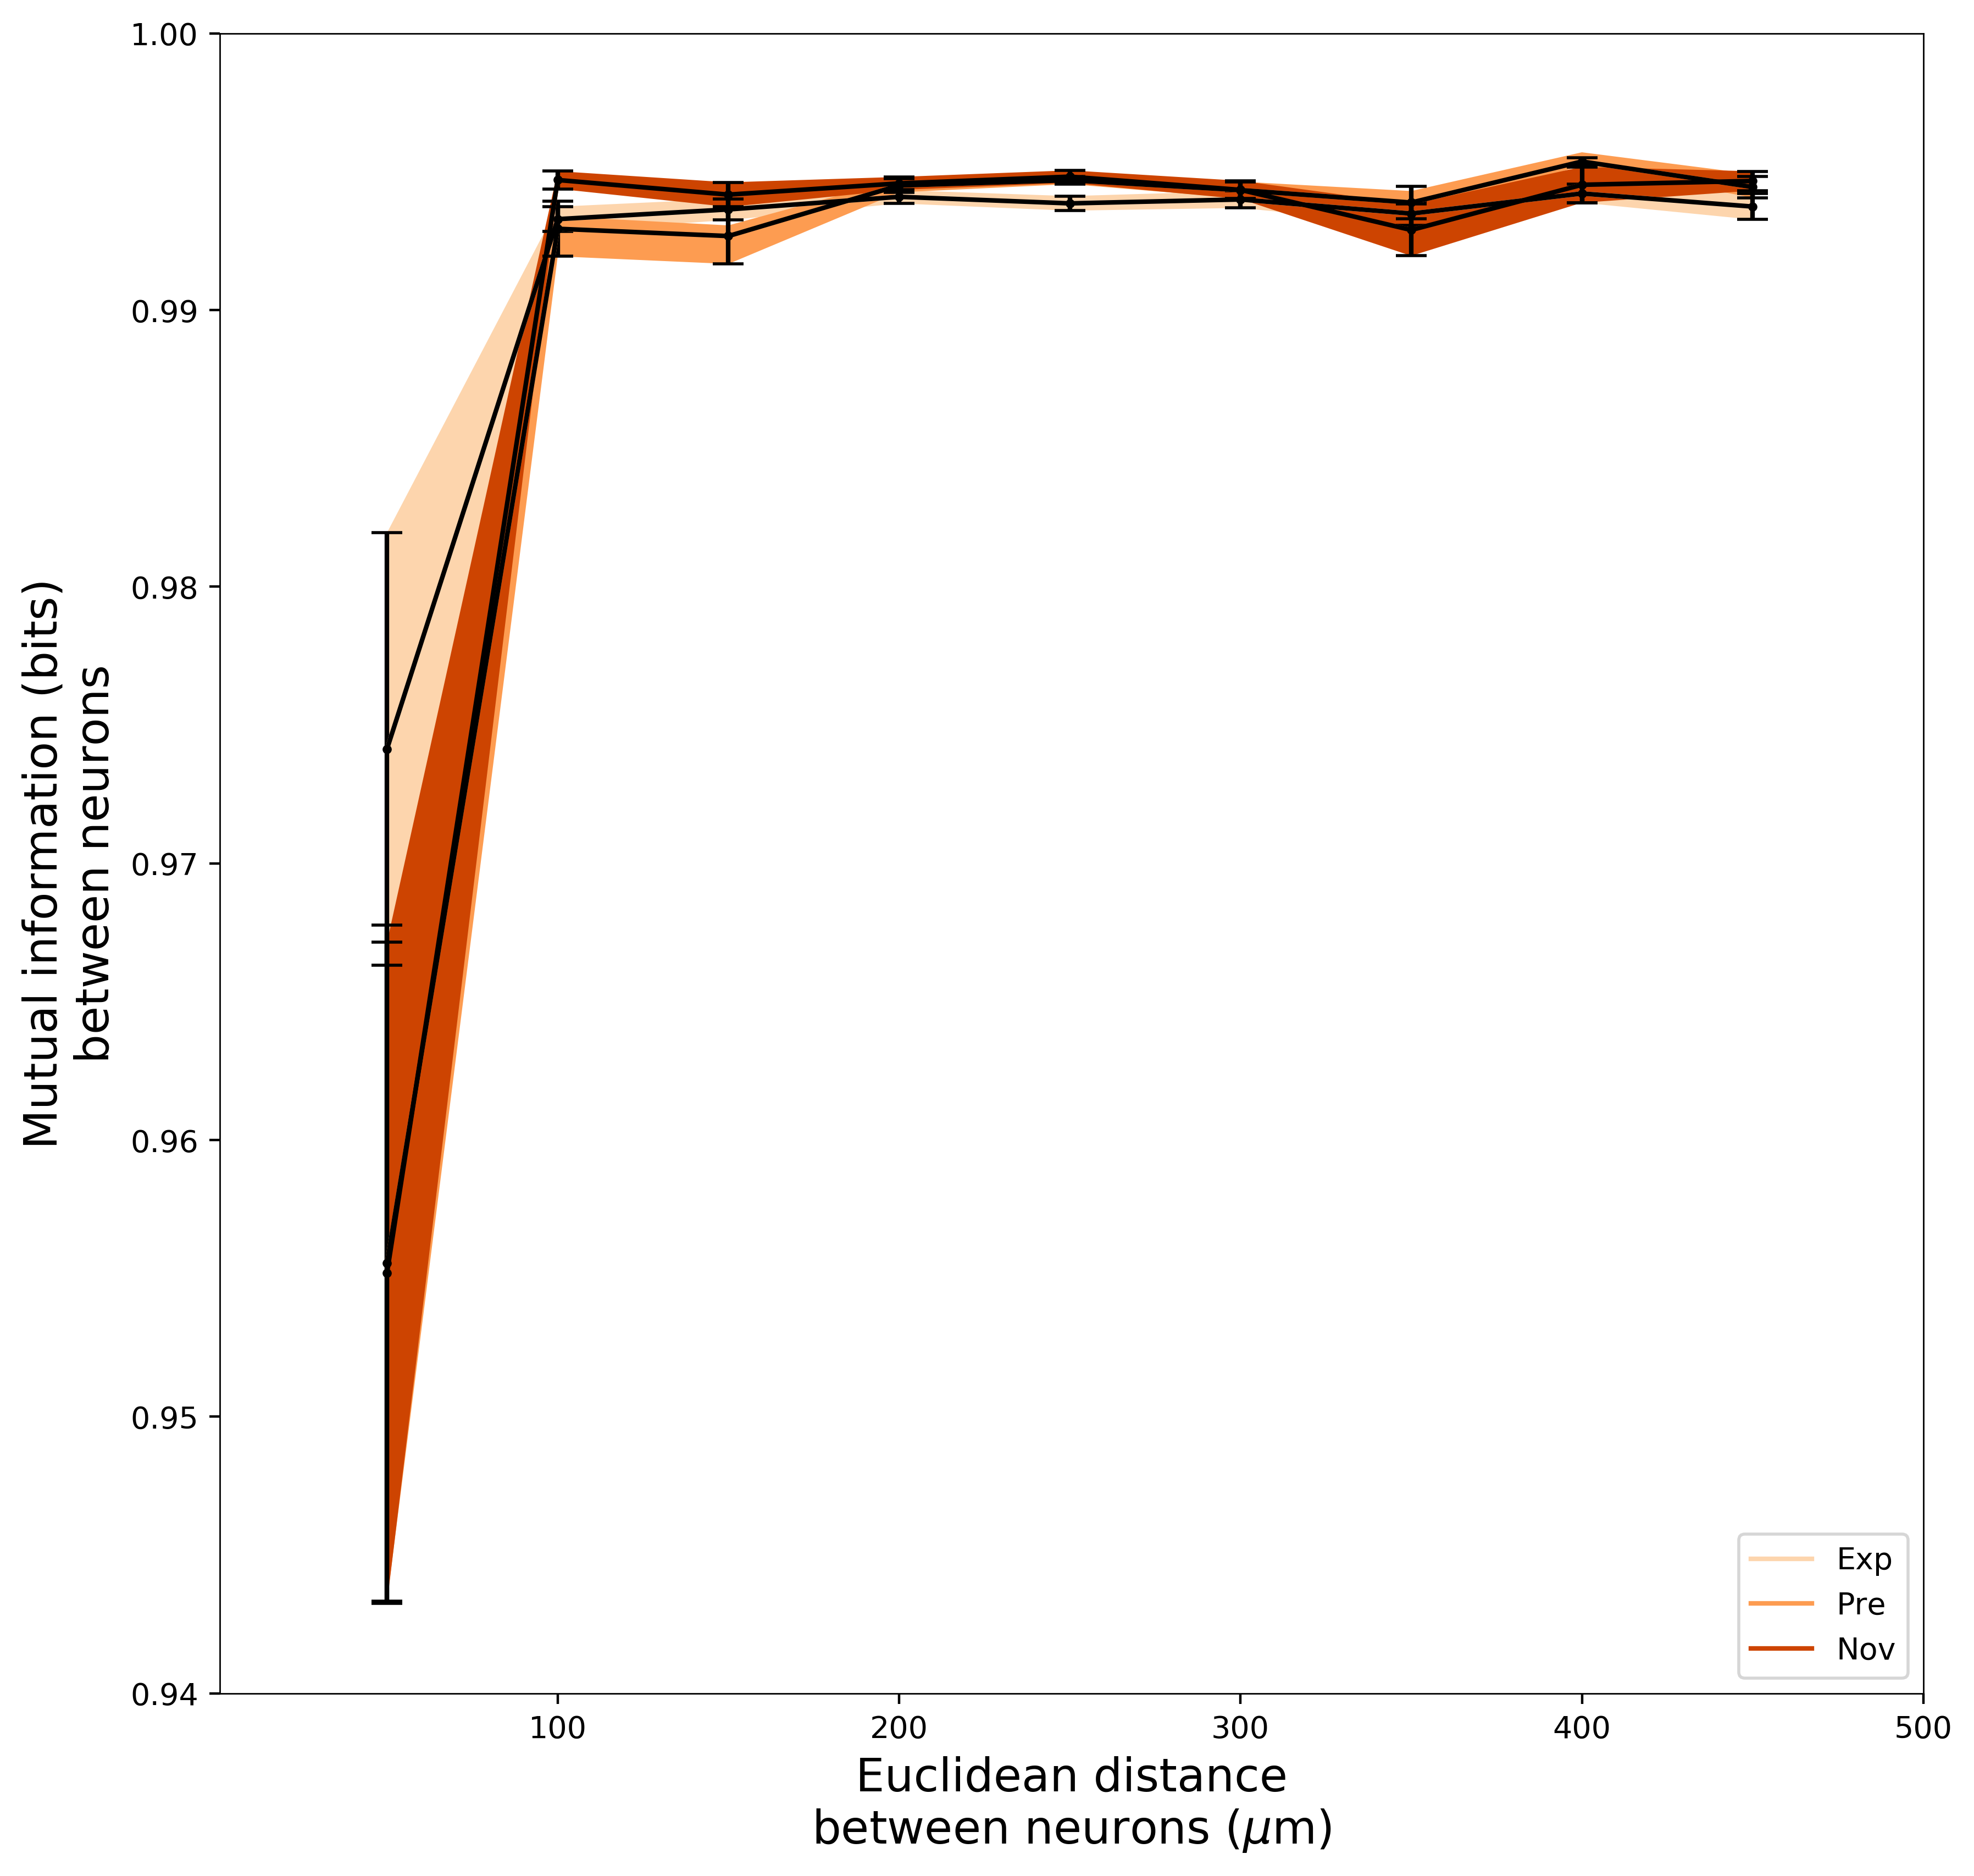

In [261]:
import matplotlib as mpl
c = np.arange(1, 10 + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap_ON = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)
cmap_OFF = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Purples)
cmap_KO = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap_KO = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)

mean_ANI_exp_x, mean_ANI_exp_y, mean_ANI_exp_err = [np.mean((np.array(ANI_x_Exp1),np.array(ANI_x_Exp2), np.array(ANI_x_Exp3)), axis=0),
                                        np.mean((np.array(ANI_y_Exp1), np.array(ANI_y_Exp2), np.array(ANI_y_Exp3)), axis=0),
                                        np.mean((np.array(ANI_err_Exp1), np.array(ANI_err_Exp2), np.array(ANI_err_Exp3)), axis=0)]

mean_ANI_pre_x, mean_ANI_pre_y, mean_ANI_pre_err = [np.mean((np.array(ANI_x_Pre1),np.array(ANI_x_Pre2)), axis=0),
                                        np.mean((np.array(ANI_y_Pre1), np.array(ANI_y_Pre2)), axis=0),
                                        np.mean((np.array(ANI_err_Pre1), np.array(ANI_err_Pre2)), axis=0)]

mean_ANI_nov_x, mean_ANI_nov_y, mean_ANI_nov_err = [np.mean((np.array(ANI_x_Nov1),np.array(ANI_x_Nov2), np.array(ANI_x_Nov3)), axis=0),
                                        np.mean((np.array(ANI_y_Nov1), np.array(ANI_y_Nov2), np.array(ANI_y_Nov3)), axis=0),
                                        np.mean((np.array(ANI_err_Nov1), np.array(ANI_err_Nov2), np.array(ANI_err_Nov3)), axis=0)]


mean_ANI_x, mean_ANI_y, mean_ANI_err = [np.mean((np.array(mean_ANI_exp_x),np.array(mean_ANI_pre_x), np.array(mean_ANI_nov_x)), axis=0),
                                        np.mean((np.array(mean_ANI_exp_y), np.array(mean_ANI_pre_y), np.array(mean_ANI_nov_y)), axis=0),
                                        np.mean((np.array(mean_ANI_exp_err), np.array(mean_ANI_pre_err), np.array(mean_ANI_nov_err)), axis=0)]

fig = plt.figure(num=None, figsize=(10, 10), dpi=400, facecolor='w', edgecolor='k')
# plt.plot(mean_ANI_x, mean_ANI_y, color = 'k')
# plt.errorbar(mean_ANI_x, mean_ANI_y, yerr=mean_ANI_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
# plt.fill_between(np.array(mean_ANI_x), np.array(mean_ANI_y)-np.array(mean_ANI_err), np.array(mean_ANI_y)+np.array(mean_ANI_err), facecolor='gray')

plt.plot(mean_ANI_exp_x, mean_ANI_exp_y, color = cmap_KO.to_rgba(3))
plt.errorbar(mean_ANI_exp_x, mean_ANI_exp_y, yerr=mean_ANI_exp_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
plt.fill_between(np.array(mean_ANI_exp_x), np.array(mean_ANI_exp_y)-np.array(mean_ANI_exp_err), np.array(mean_ANI_exp_y)+np.array(mean_ANI_exp_err), facecolor=cmap_KO.to_rgba(3))

plt.plot(mean_ANI_pre_x, mean_ANI_pre_y, color = cmap_KO.to_rgba(5))
plt.errorbar(mean_ANI_pre_x, mean_ANI_pre_y, yerr=mean_ANI_pre_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
plt.fill_between(np.array(mean_ANI_pre_x), np.array(mean_ANI_pre_y)-np.array(mean_ANI_pre_err), np.array(mean_ANI_pre_y)+np.array(mean_ANI_exp_err), facecolor=cmap_KO.to_rgba(5))

plt.plot(mean_ANI_nov_x, mean_ANI_nov_y, color = cmap_KO.to_rgba(8))
plt.errorbar(mean_ANI_nov_x, mean_ANI_nov_y, yerr=mean_ANI_nov_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
plt.fill_between(np.array(mean_ANI_nov_x), np.array(mean_ANI_nov_y)-np.array(mean_ANI_nov_err), np.array(mean_ANI_nov_y)+np.array(mean_ANI_nov_err), facecolor=cmap_KO.to_rgba(8))

plt.legend(['Exp', 'Pre', 'Nov'], loc=4)
plt.xlabel(r'Euclidean distance' + '\n' + 'between neurons ($\mu$m)')
plt.ylabel('Mutual information (bits)' + '\n' + 'between neurons')    
plt.xlim(1, 500)
plt.ylim(0.94, 1)
plt.savefig('/Users/rufusmitchell-heggs/Desktop/Thesis/all_figures/MIvsEUCdis_ANI_KO.png', format='png', dpi=600, bbox_inches = 'tight')

# plt.ylim(0, 0.1)

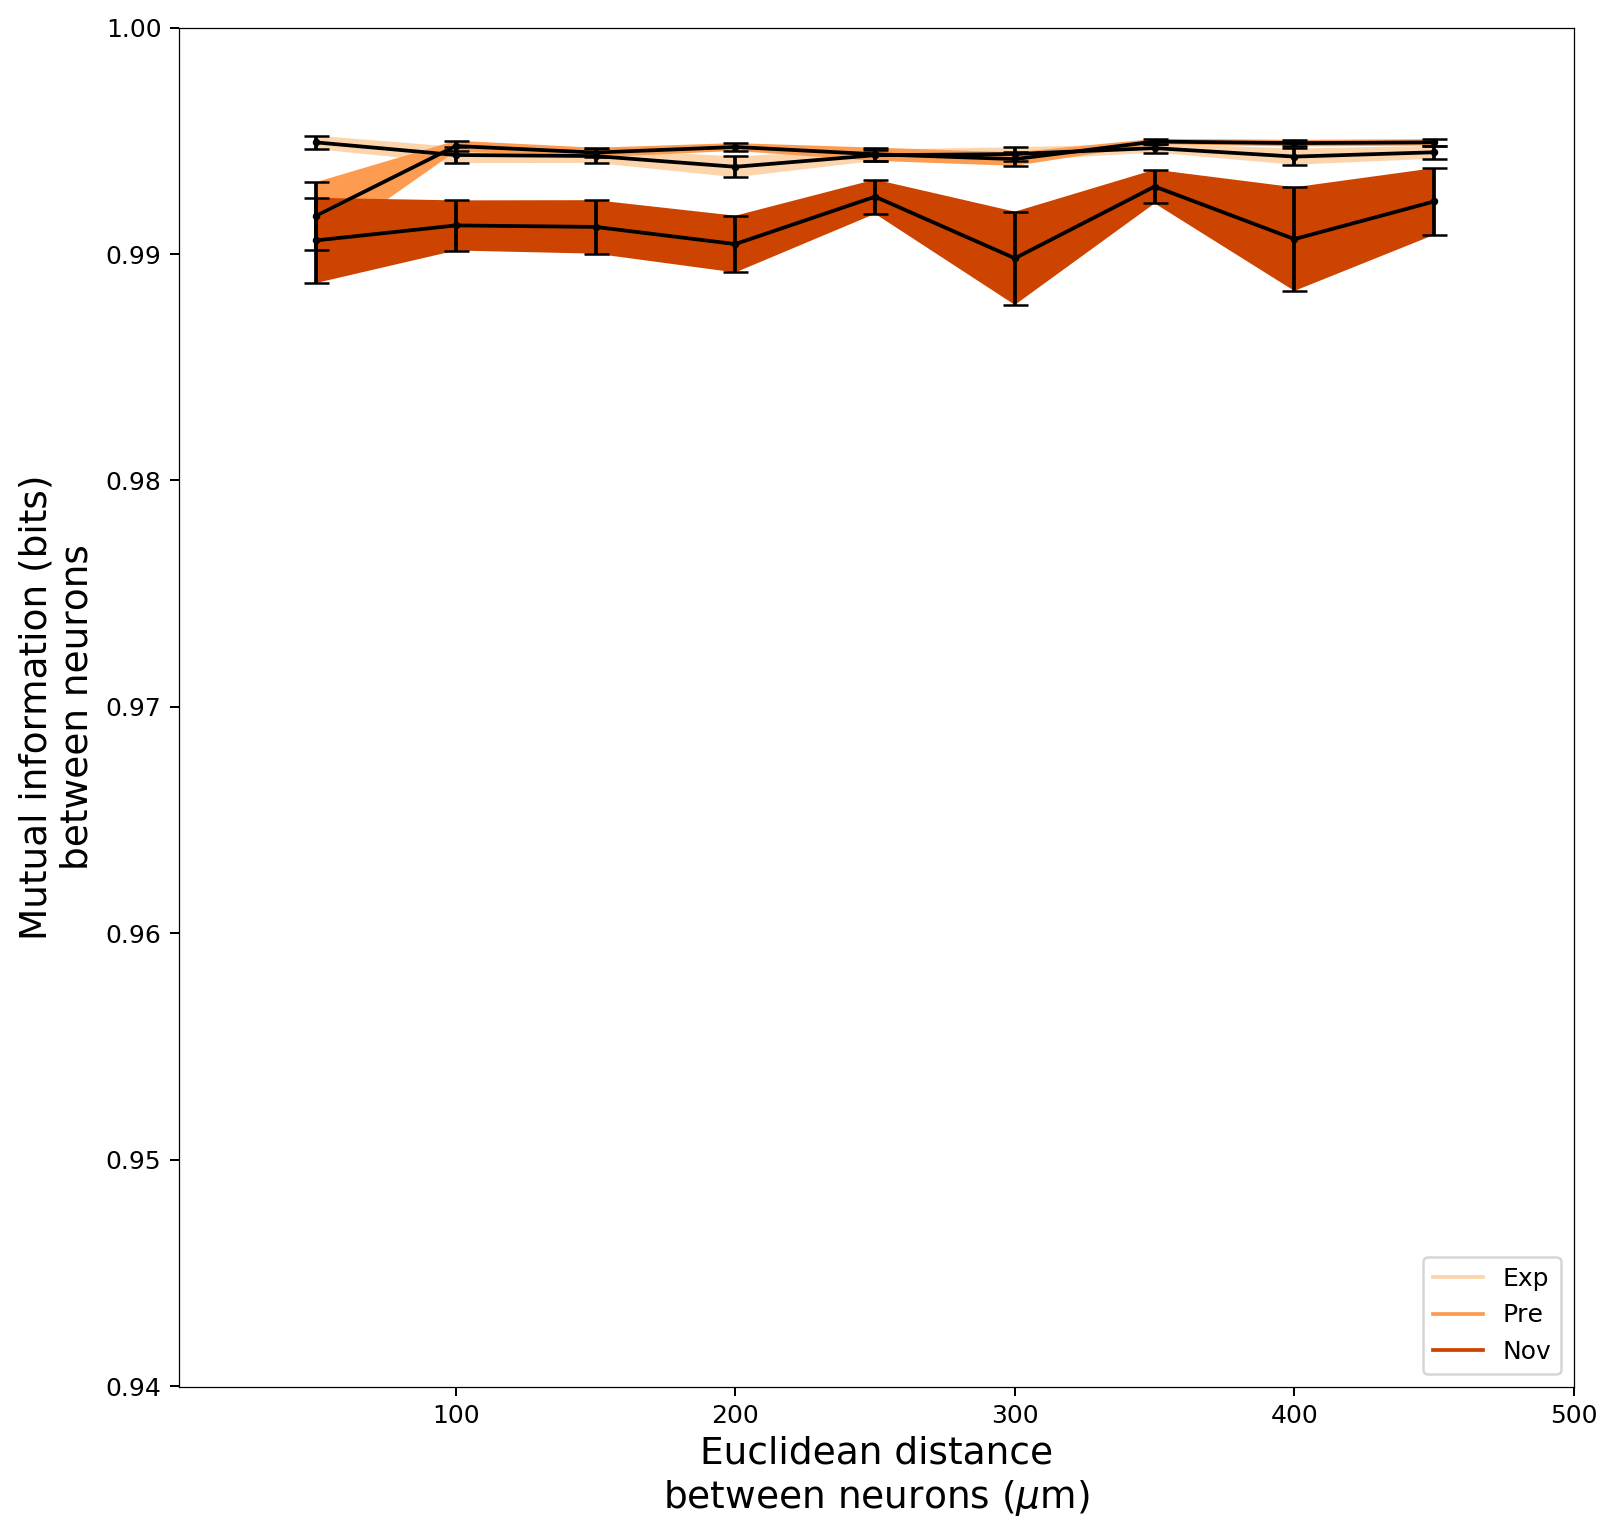

In [262]:
mean_ANL_exp_x, mean_ANL_exp_y, mean_ANL_exp_err = [np.mean((np.array(ANL_x_Exp1),np.array(ANL_x_Exp2), np.array(ANL_x_Exp3)), axis=0),
                                        np.mean((np.array(ANL_y_Exp1), np.array(ANL_y_Exp2), np.array(ANL_y_Exp3)), axis=0),
                                        np.mean((np.array(ANL_err_Exp1), np.array(ANL_err_Exp2), np.array(ANL_err_Exp3)), axis=0)]

mean_ANL_pre_x, mean_ANL_pre_y, mean_ANL_pre_err = [np.mean((np.array(ANL_x_Pre1),np.array(ANL_x_Pre2)), axis=0),
                                        np.mean((np.array(ANL_y_Pre1), np.array(ANL_y_Pre2)), axis=0),
                                        np.mean((np.array(ANL_err_Pre1), np.array(ANL_err_Pre2)), axis=0)]

mean_ANL_nov_x, mean_ANL_nov_y, mean_ANL_nov_err = [np.mean((np.array(ANL_x_Nov1),np.array(ANL_x_Nov2), np.array(ANL_x_Nov3)), axis=0),
                                        np.mean((np.array(ANL_y_Nov1), np.array(ANL_y_Nov2), np.array(ANL_y_Nov3)), axis=0),
                                        np.mean((np.array(ANL_err_Nov1), np.array(ANL_err_Nov2), np.array(ANL_err_Nov3)), axis=0)]


mean_ANL_x, mean_ANL_y, mean_ANL_err = [np.mean((np.array(mean_ANL_exp_x),np.array(mean_ANL_pre_x), np.array(mean_ANL_nov_x)), axis=0),
                                        np.mean((np.array(mean_ANL_exp_y), np.array(mean_ANL_pre_y), np.array(mean_ANL_nov_y)), axis=0),
                                        np.mean((np.array(mean_ANL_exp_err), np.array(mean_ANL_pre_err), np.array(mean_ANL_nov_err)), axis=0)]

fig = plt.figure(num=None, figsize=(10, 10), dpi=180, facecolor='w', edgecolor='k')
# plt.plot(mean_ANL_x, mean_ANL_y, color = 'k')
# plt.errorbar(mean_ANL_x, mean_ANL_y, yerr=mean_ANL_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
# plt.fill_between(np.array(mean_ANL_x), np.array(mean_ANL_y)-np.array(mean_ANL_err), np.array(mean_ANL_y)+np.array(mean_ANL_err), facecolor='gray')

plt.plot(mean_ANL_exp_x, mean_ANL_exp_y, color = cmap_KO.to_rgba(3))
plt.errorbar(mean_ANL_exp_x, mean_ANL_exp_y, yerr=mean_ANL_exp_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
plt.fill_between(np.array(mean_ANL_exp_x), np.array(mean_ANL_exp_y)-np.array(mean_ANL_exp_err), np.array(mean_ANL_exp_y)+np.array(mean_ANL_exp_err), facecolor=cmap_KO.to_rgba(3))

plt.plot(mean_ANL_pre_x, mean_ANL_pre_y, color = cmap_KO.to_rgba(5))
plt.errorbar(mean_ANL_pre_x, mean_ANL_pre_y, yerr=mean_ANL_pre_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
plt.fill_between(np.array(mean_ANL_pre_x), np.array(mean_ANL_pre_y)-np.array(mean_ANL_pre_err), np.array(mean_ANL_pre_y)+np.array(mean_ANL_pre_err), facecolor=cmap_KO.to_rgba(5))

plt.plot(mean_ANL_nov_x, mean_ANL_nov_y, color = cmap_KO.to_rgba(8))
plt.errorbar(mean_ANL_nov_x, mean_ANL_nov_y, yerr=mean_ANL_nov_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
plt.fill_between(np.array(mean_ANL_nov_x), np.array(mean_ANL_nov_y)-np.array(mean_ANL_nov_err), np.array(mean_ANL_nov_y)+np.array(mean_ANL_nov_err), facecolor=cmap_KO.to_rgba(8))


plt.xlabel(r'Euclidean distance' + '\n' + 'between neurons ($\mu$m)')
plt.ylabel('Mutual information (bits)' + '\n' + 'between neurons')    
plt.xlim(1, 500)
plt.ylim(0.94, 1)
plt.legend(['Exp', 'Pre', 'Nov'], loc=4)

plt.savefig('/Users/rufusmitchell-heggs/Desktop/Thesis/all_figures/MIvsEUCdis_ANL_KO.png', format='png', dpi=600, bbox_inches = 'tight')



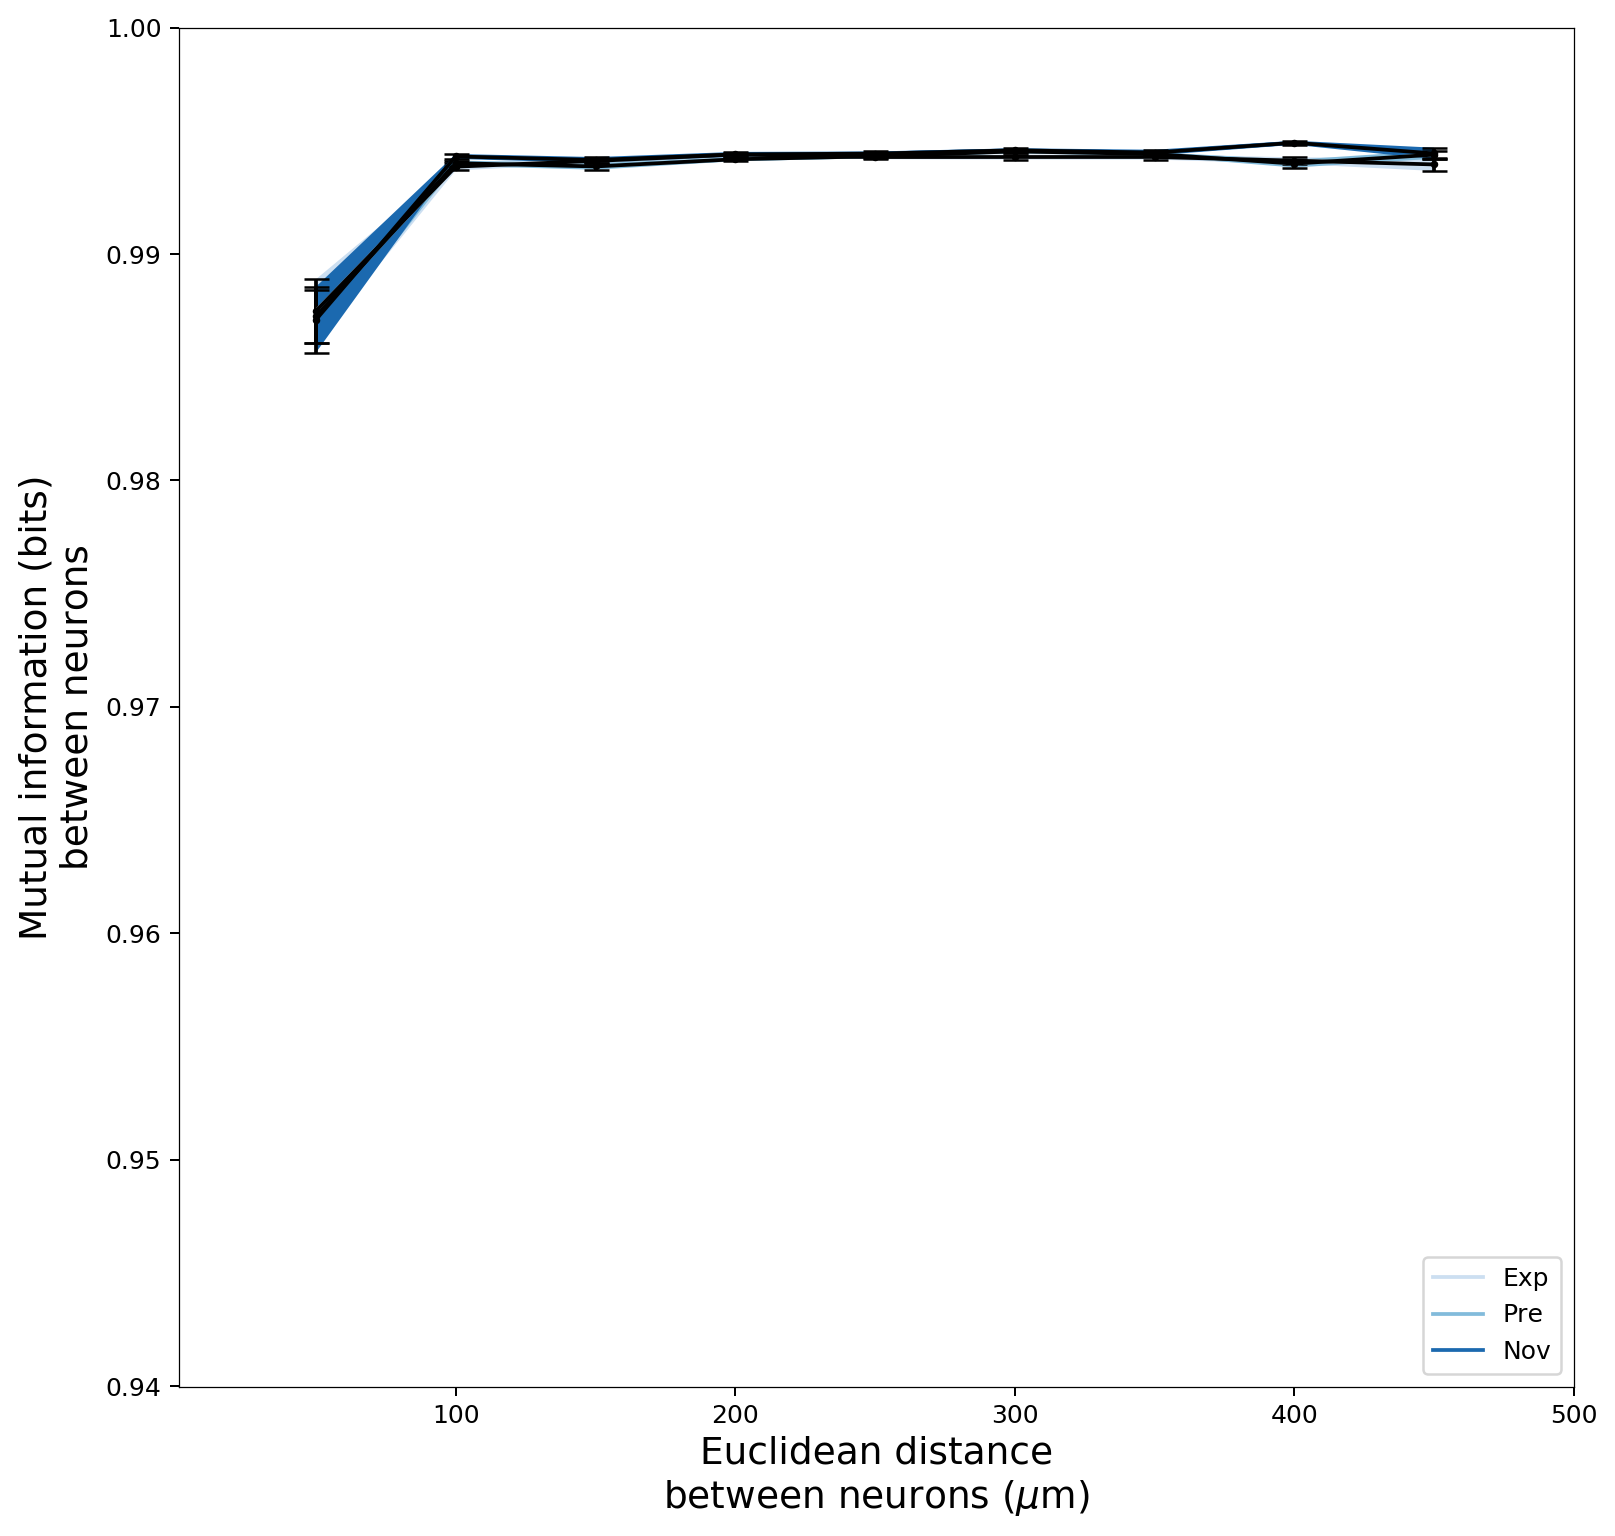

In [263]:
mean_ANF_exp_x, mean_ANF_exp_y, mean_ANF_exp_err = [np.mean((np.array(ANF_x_Exp1),np.array(ANF_x_Exp2), np.array(ANF_x_Exp3)), axis=0),
                                        np.mean((np.array(ANF_y_Exp1), np.array(ANF_y_Exp2), np.array(ANF_y_Exp3)), axis=0),
                                        np.mean((np.array(ANF_err_Exp1), np.array(ANF_err_Exp2), np.array(ANF_err_Exp3)), axis=0)]

mean_ANF_pre_x, mean_ANF_pre_y, mean_ANF_pre_err = [np.mean((np.array(ANF_x_Pre1),np.array(ANF_x_Pre2)), axis=0),
                                        np.mean((np.array(ANF_y_Pre1), np.array(ANF_y_Pre2)), axis=0),
                                        np.mean((np.array(ANF_err_Pre1), np.array(ANF_err_Pre2)), axis=0)]

mean_ANF_nov_x, mean_ANF_nov_y, mean_ANF_nov_err = [np.mean((np.array(ANF_x_Nov1),np.array(ANF_x_Nov2), np.array(ANF_x_Nov3)), axis=0),
                                        np.mean((np.array(ANF_y_Nov1), np.array(ANF_y_Nov2), np.array(ANF_y_Nov3)), axis=0),
                                        np.mean((np.array(ANF_err_Nov1), np.array(ANF_err_Nov2), np.array(ANF_err_Nov3)), axis=0)]

mean_ANF_x, mean_ANF_y, mean_ANF_err = [np.mean((np.array(mean_ANF_exp_x),np.array(mean_ANF_pre_x), np.array(mean_ANF_nov_x)), axis=0),
                                        np.mean((np.array(mean_ANF_exp_y), np.array(mean_ANF_pre_y), np.array(mean_ANF_nov_y)), axis=0),
                                        np.mean((np.array(mean_ANF_exp_err), np.array(mean_ANF_pre_err), np.array(mean_ANF_nov_err)), axis=0)]



#--------------------------------------------------------------------------------------------------

fig = plt.figure(num=None, figsize=(10, 10), dpi=180, facecolor='w', edgecolor='k')
# plt.plot(mean_ANF_x, mean_ANF_y, color = 'k')
# plt.errorbar(mean_ANF_x, mean_ANF_y, yerr=mean_ANF_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
# plt.fill_between(np.array(mean_ANF_x), np.array(mean_ANF_y)-np.array(mean_ANF_err), np.array(mean_ANF_y)+np.array(mean_ANF_err), facecolor='gray')

plt.plot(mean_ANF_exp_x, mean_ANF_exp_y, color = cmap_WT.to_rgba(3))
plt.errorbar(mean_ANF_exp_x, mean_ANF_exp_y, yerr=mean_ANF_exp_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
plt.fill_between(np.array(mean_ANF_exp_x), np.array(mean_ANF_exp_y)-np.array(mean_ANF_exp_err), np.array(mean_ANF_exp_y)+np.array(mean_ANF_exp_err), facecolor=cmap_WT.to_rgba(3))

plt.plot(mean_ANF_pre_x, mean_ANF_pre_y, color = cmap_WT.to_rgba(5))
plt.errorbar(mean_ANF_pre_x, mean_ANF_pre_y, yerr=mean_ANF_pre_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
plt.fill_between(np.array(mean_ANF_pre_x), np.array(mean_ANF_pre_y)-np.array(mean_ANF_pre_err), np.array(mean_ANF_pre_y)+np.array(mean_ANF_pre_err), facecolor=cmap_WT.to_rgba(5))

plt.plot(mean_ANF_nov_x, mean_ANF_nov_y, color = cmap_WT.to_rgba(8))
plt.errorbar(mean_ANF_nov_x, mean_ANF_nov_y, yerr=mean_ANF_nov_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
plt.fill_between(np.array(mean_ANF_nov_x), np.array(mean_ANF_nov_y)-np.array(mean_ANF_nov_err), np.array(mean_ANF_nov_y)+np.array(mean_ANF_nov_err), facecolor=cmap_WT.to_rgba(8))

plt.xlabel(r'Euclidean distance' + '\n' + 'between neurons ($\mu$m)')
plt.ylabel('Mutual information (bits)' + '\n' + 'between neurons')    
plt.xlim(1, 500)
plt.legend(['Exp', 'Pre', 'Nov'], loc=4)
plt.ylim(0.94, 1)
plt.savefig('/Users/rufusmitchell-heggs/Desktop/Thesis/all_figures/MIvsEUCdis_ANF_WT.png', format='png', dpi=600, bbox_inches = 'tight')

# plt.ylim(0, 0.1)

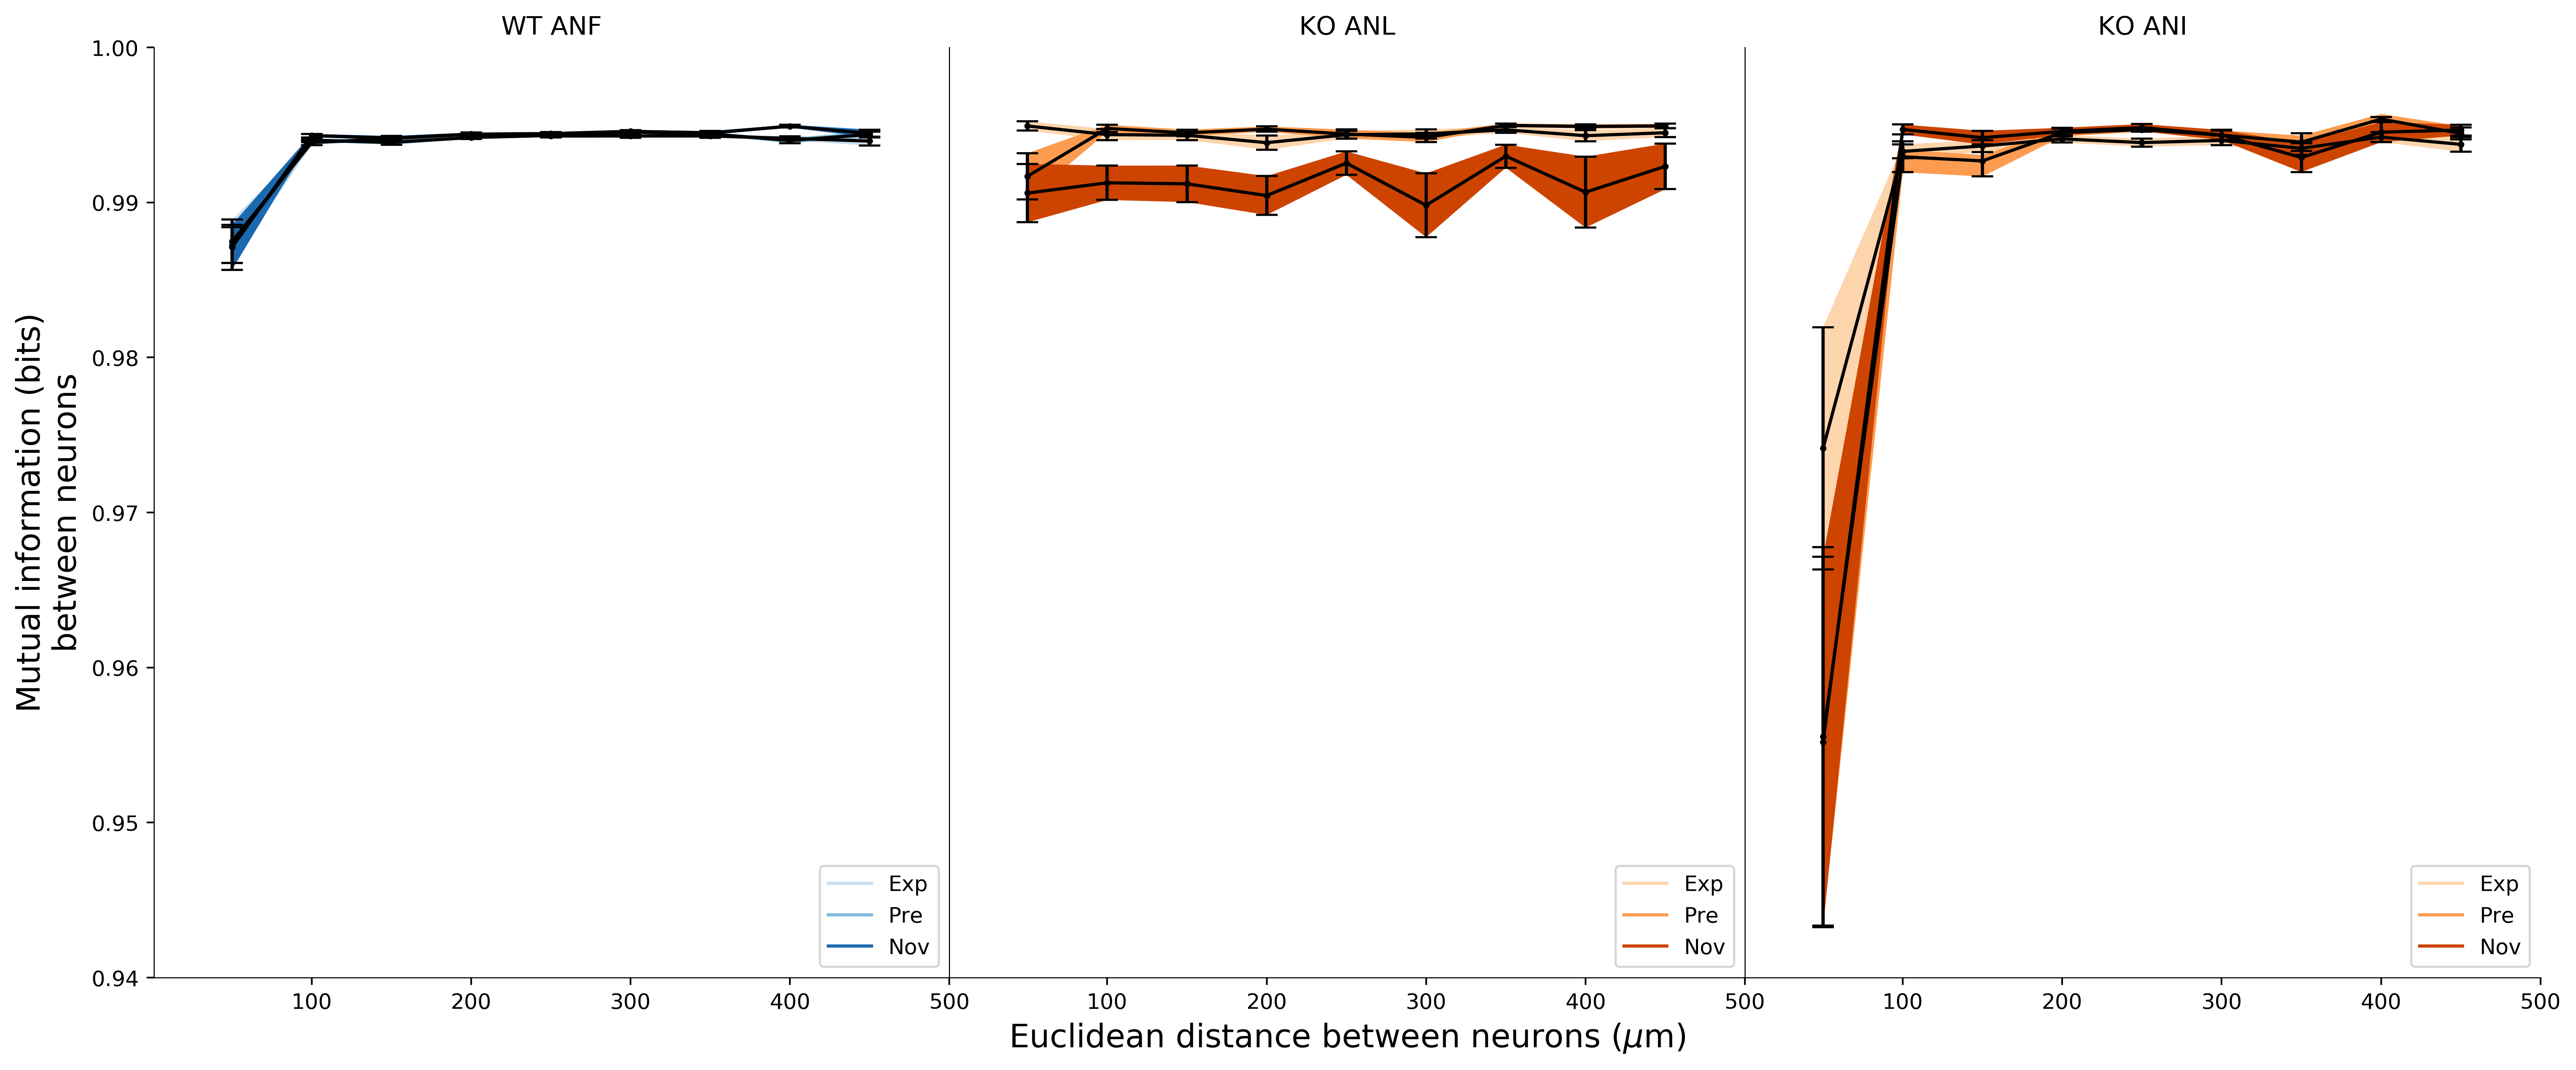

In [271]:
fig, axs = plt.subplots(1, 3, figsize=(20,8), dpi=400, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(1, 3)

axs[0] = plt.subplot(gs[0])
axs[0] = plt.plot(mean_ANF_exp_x, mean_ANF_exp_y, color = cmap_WT.to_rgba(3))
axs[0] = plt.errorbar(mean_ANF_exp_x, mean_ANF_exp_y, yerr=mean_ANF_exp_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
axs[0] = plt.fill_between(np.array(mean_ANF_exp_x), np.array(mean_ANF_exp_y)-np.array(mean_ANF_exp_err), np.array(mean_ANF_exp_y)+np.array(mean_ANF_exp_err), facecolor=cmap_WT.to_rgba(3))

axs[0] = plt.plot(mean_ANF_pre_x, mean_ANF_pre_y, color = cmap_WT.to_rgba(5))
axs[0] = plt.errorbar(mean_ANF_pre_x, mean_ANF_pre_y, yerr=mean_ANF_pre_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
axs[0] = plt.fill_between(np.array(mean_ANF_pre_x), np.array(mean_ANF_pre_y)-np.array(mean_ANF_pre_err), np.array(mean_ANF_pre_y)+np.array(mean_ANF_pre_err), facecolor=cmap_WT.to_rgba(5))

axs[0] = plt.plot(mean_ANF_nov_x, mean_ANF_nov_y, color = cmap_WT.to_rgba(8))
axs[0] = plt.errorbar(mean_ANF_nov_x, mean_ANF_nov_y, yerr=mean_ANF_nov_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
axs[0] = plt.fill_between(np.array(mean_ANF_nov_x), np.array(mean_ANF_nov_y)-np.array(mean_ANF_nov_err), np.array(mean_ANF_nov_y)+np.array(mean_ANF_nov_err), facecolor=cmap_WT.to_rgba(8))

axs[0] = plt.title('WT ANF')
axs[0] = plt.ylabel('Mutual information (bits)' + '\n' + 'between neurons')    
axs[0] = plt.xlim(1, 500)
axs[0] = plt.ylim(0.94, 1)
axs[0] = plt.legend(['Exp', 'Pre', 'Nov'], loc=4)
axs[0] = sns.despine()
axs[0] = plt.tick_params(bottom=True, left=True, right=False, labelleft=True, labelbottom=True)
#--------------------------------------------------------------------------------------------------
axs[1] = plt.subplot(gs[1])
axs[1] = plt.plot(mean_ANL_exp_x, mean_ANL_exp_y, color = cmap_KO.to_rgba(3))
axs[1] = plt.errorbar(mean_ANL_exp_x, mean_ANL_exp_y, yerr=mean_ANL_exp_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
axs[1] = plt.fill_between(np.array(mean_ANL_exp_x), np.array(mean_ANL_exp_y)-np.array(mean_ANL_exp_err), np.array(mean_ANL_exp_y)+np.array(mean_ANL_exp_err), facecolor=cmap_KO.to_rgba(3))

axs[1] = plt.plot(mean_ANL_pre_x, mean_ANL_pre_y, color = cmap_KO.to_rgba(5))
axs[1] = plt.errorbar(mean_ANL_pre_x, mean_ANL_pre_y, yerr=mean_ANL_pre_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
axs[1] = plt.fill_between(np.array(mean_ANL_pre_x), np.array(mean_ANL_pre_y)-np.array(mean_ANL_pre_err), np.array(mean_ANL_pre_y)+np.array(mean_ANL_pre_err), facecolor=cmap_KO.to_rgba(5))

axs[1] = plt.plot(mean_ANL_nov_x, mean_ANL_nov_y, color = cmap_KO.to_rgba(8))
axs[1] = plt.errorbar(mean_ANL_nov_x, mean_ANL_nov_y, yerr=mean_ANL_nov_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
axs[1] = plt.fill_between(np.array(mean_ANL_nov_x), np.array(mean_ANL_nov_y)-np.array(mean_ANL_nov_err), np.array(mean_ANL_nov_y)+np.array(mean_ANL_nov_err), facecolor=cmap_KO.to_rgba(8))

axs[1] = plt.title('KO ANL')
axs[1] = plt.xlabel(r'Euclidean distance between neurons ($\mu$m)')
axs[1] = plt.xlim(1, 500)
axs[1] = plt.ylim(0.94, 1)
axs[1] = plt.legend(['Exp', 'Pre', 'Nov'], loc=4)
axs[1] = sns.despine()
axs[1] = plt.tick_params(bottom=True, left=False, right=False, labelleft=False, labelbottom=True)
#--------------------------------------------------------------------------------------------------
axs[2] = plt.subplot(gs[2])
axs[2] = plt.plot(mean_ANI_exp_x, mean_ANI_exp_y, color = cmap_KO.to_rgba(3))
axs[2] = plt.errorbar(mean_ANI_exp_x, mean_ANI_exp_y, yerr=mean_ANI_exp_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
axs[2] = plt.fill_between(np.array(mean_ANI_exp_x), np.array(mean_ANI_exp_y)-np.array(mean_ANI_exp_err), np.array(mean_ANI_exp_y)+np.array(mean_ANI_exp_err), facecolor=cmap_KO.to_rgba(3))

axs[2] = plt.plot(mean_ANI_pre_x, mean_ANI_pre_y, color = cmap_KO.to_rgba(5))
axs[2] = plt.errorbar(mean_ANI_pre_x, mean_ANI_pre_y, yerr=mean_ANI_pre_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
axs[2] = plt.fill_between(np.array(mean_ANI_pre_x), np.array(mean_ANI_pre_y)-np.array(mean_ANI_pre_err), np.array(mean_ANI_pre_y)+np.array(mean_ANI_exp_err), facecolor=cmap_KO.to_rgba(5))

axs[2] = plt.plot(mean_ANI_nov_x, mean_ANI_nov_y, color = cmap_KO.to_rgba(8))
axs[2] = plt.errorbar(mean_ANI_nov_x, mean_ANI_nov_y, yerr=mean_ANI_nov_err, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')
axs[2] = plt.fill_between(np.array(mean_ANI_nov_x), np.array(mean_ANI_nov_y)-np.array(mean_ANI_nov_err), np.array(mean_ANI_nov_y)+np.array(mean_ANI_nov_err), facecolor=cmap_KO.to_rgba(8))

axs[2] = plt.title('KO ANI')
axs[2] = plt.legend(['Exp', 'Pre', 'Nov'], loc=4)
axs[2] = plt.xlim(1, 500)
axs[2] = plt.ylim(0.94, 1)
axs[2] = sns.despine()

axs[2] = plt.tick_params(bottom=True, left=False, right=False, labelleft=False, labelbottom=True)

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('/Users/rufusmitchell-heggs/Desktop/Thesis/all_figures/MIvseucdis_all.png', format='png', dpi=600, bbox_inches = 'tight')
plt.show()

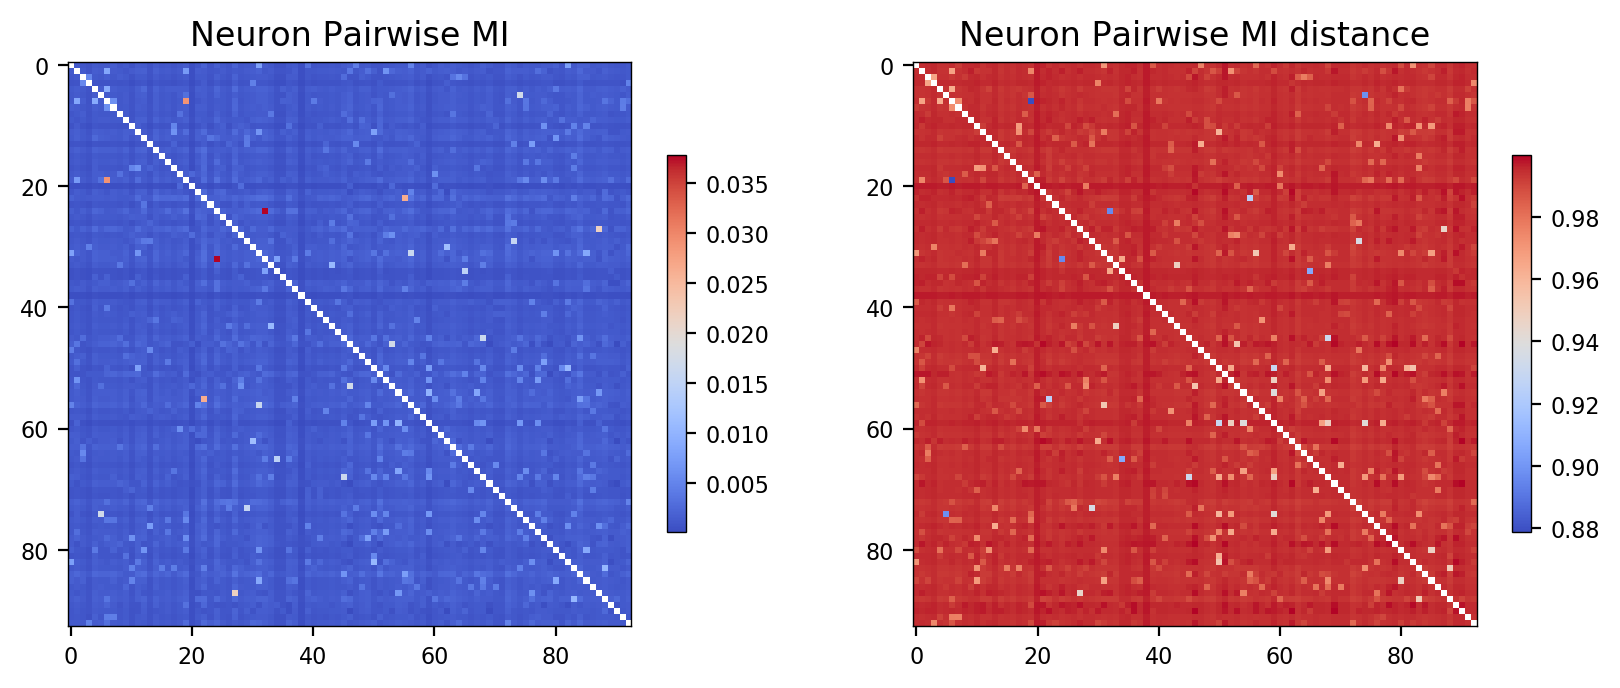

In [442]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), dpi=200, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(1, 2) 

axs[0] = plt.subplot(gs[0])
axs[0] = plt.imshow(mi_all, cmap="coolwarm")
axs[0] = plt.title("Neuron Pairwise MI")
axs[0] = plt.yticks(rotation=0)
axs[0] = plt.colorbar(shrink=0.5)

axs[1] = plt.subplot(gs[1])
axs[1] = plt.imshow(mutual_info_dis_all, cmap="coolwarm")
axs[1] = plt.title("Neuron Pairwise MI distance")
axs[1] = plt.yticks(rotation=0)
axs[1] = plt.colorbar(shrink=0.5)

In [272]:
from sklearn.datasets import load_digits
from sklearn.manifold import MDS
from sklearn import manifold

new_mi_d_all2 = []
for i in range(len(mutual_info_dis_all)):
    new_mi_d = []
    for j in range(len(mutual_info_dis_all)):
        if i == j:
            new_mi_d.append(0.8)
        else:
            new_mi_d.append(mutual_info_dis_all[i][j])
    new_mi_d_all2.append(new_mi_d)
new_mi_d_all2 = np.array(new_mi_d_all2)
            
X0 = new_mi_d_all.transpose()
X1 = new_mi_d_all1.transpose()
X2 = new_mi_d_all2.transpose()

NameError: name 'new_mi_d_all' is not defined

In [449]:
session1 = np.array([X0,X1,X2])

df1 = pd.DataFrame(X0)
df2 = pd.DataFrame(X1)
df3 = pd.DataFrame(X2)

largest = max(X0.shape[0], X1.shape[0], X2.shape[0])

frames = [df1, df2, df3]

df1_labels = pd.DataFrame(np.ones(largest-1))
df2_labels = pd.DataFrame(np.ones(largest-1)*4)
df3_labels = pd.DataFrame(np.ones(largest-1)*2)

frame_labels = [df1_labels, df2_labels, df3_labels]

results = np.array(pd.concat(frames).fillna(1))

result_labels4 = np.array(pd.concat(frame_labels)).transpose()[0]

print(results.shape, result_labels4.shape)


(283, 95) (282,)


In [445]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

digits = datasets.load_digits(n_class=6)
X = results
y = result_labels4
n_samples, n_features = X.shape
n_neighbors = 180

colors = []
for i in y:
    if i == 1:
        colors.append('gray')
    elif i == 4:
        colors.append('skyblue')
    else:
        colors.append('mediumblue')
        
X.shape[0]
print(len(colors))

282


In [446]:
from mpl_toolkits.mplot3d import Axes3D
import random

def plot3D_MDS(X_trans, colors):
    fig = plt.figure(figsize=(5, 3), dpi=200)
    ax = Axes3D(fig)
    for i in range(X_trans.shape[0]):
        ax.scatter(X_trans[i, 0], X_trans[i, 1],X_trans[i, 2], color=colors[i], s=2)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')
        ax.grid(False)
        ax.set_xlabel("MDS 1")
        ax.set_ylabel("MDS 2")
        ax.set_zlabel("MDS 3")
# ---------------------------------------------------------------------    
# Projection on to the first 2 linear discriminant components
print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=3).fit_transform(X2, y)
# ----------------------------------------------------------------------
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
clf = manifold.MDS(n_components=3, n_init=1, max_iter=1)
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
# ----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot3D_MDS(X_mds, colors)
plot3D_MDS(X_tsne, colors)

fig = plt.figure(figsize=(5, 3), dpi=200)
for i in range(X_lda.shape[0]):
    plt.scatter(X_lda[i, 0], X_lda[i, 1], color=colors[i], s=2)
    plt.xlabel("LD1")
    plt.ylabel("LD2")

Computing Linear Discriminant Analysis projection


ValueError: Found input variables with inconsistent numbers of samples: [283, 282]